<a href="https://colab.research.google.com/github/KczePK/District-level-yield-prediction/blob/main/India's_Agriculture_crop_yield_prediction_model_using_ICRISAT_District_Level_Database.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data Source
Data derived from the ICRISAT District Level Database (DLD)  
http://data.icrisat.org/dld/index.html  
Licensed under CC BY 4.0




---

# Project Overview: India District Level annual crop yields prediction from fertilizer consumption, rainfall and soil type.


Notebook by: Nawa P.


This project applies machine learning techniques to publicly available agricultural data from India to analyze the relationship between soil types, fertilizer usage,rainfall and crop yields at the district level, the project develops predictive models and exploratory analyses which highlight important drivers of agricultural productivity.

The approach and insights from this work can be extended to datasets from Thailand’s Land Development Department (กรมพัฒนาที่ดิน [link](https://osd101.ldd.go.th/)) to support data-driven agricultural planning and research in Thailand.

Business objective: The model's output (a prediction of a district’s crop yield) will be use to determine which type of crops (or which districts for that type of crops) are worth investing for policy maker.

Hypothetical situation: Afrer communitcating with the policy maker team, it is clear that the downstream system that they will be using is going to need the output to be a numeric value for comparisons.

Project aim:

Predict crop yield from fertilizer consumption, rainfall, soil type, and geospatial data



In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

BASE_URL = "https://raw.githubusercontent.com/KczePK/District-level-yield-prediction/main/data"

crop_data       = pd.read_csv(f"{BASE_URL}/AreaProductionYield.csv")
fertilizer_data = pd.read_csv(f"{BASE_URL}/FertilizerConsumption.csv")
soil_data       = pd.read_csv(f"{BASE_URL}/SoilType.csv")
rainfall_data   = pd.read_csv(f"{BASE_URL}/RainFall.csv")
identifiers_data= pd.read_csv(f"{BASE_URL}/Identifiers.csv")

# Exploratory Data Analysis


In [2]:
#Looking at raw data
print(crop_data.info())
print(fertilizer_data.info())
print(soil_data.info())
print(rainfall_data.info())
print(identifiers_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16146 entries, 0 to 16145
Data columns (total 80 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Dist Code                                    16146 non-null  int64  
 1   Year                                         16146 non-null  int64  
 2   State Code                                   16146 non-null  int64  
 3   State Name                                   16146 non-null  object 
 4   Dist Name                                    16146 non-null  object 
 5   RICE AREA (1000 ha)                          16146 non-null  float64
 6   RICE PRODUCTION (1000 tons)                  16146 non-null  float64
 7   RICE YIELD (Kg per ha)                       16146 non-null  float64
 8   WHEAT AREA (1000 ha)                         16146 non-null  float64
 9   WHEAT PRODUCTION (1000 tons)                 16146 non-null  float64
 10

In [3]:
crop_data.describe()

Dist Code          Year    State Code  RICE AREA (1000 ha)  \
count  16146.000000  16146.000000  16146.000000         16146.000000   
mean     269.769231   1991.496841      9.568562           128.593192   
std      278.309125     15.011185      4.988538           160.078825   
min        1.000000   1966.000000      1.000000            -1.000000   
25%       78.000000   1978.000000      6.000000            10.400000   
50%      156.000000   1991.000000     10.000000            66.800000   
75%      241.000000   2005.000000     12.000000           191.390000   
max      917.000000   2017.000000     20.000000          1154.230000   

       RICE PRODUCTION (1000 tons)  RICE YIELD (Kg per ha)  \
count                 16146.000000            16146.000000   
mean                    224.889565             1486.924784   
std                     326.629828              956.185281   
min                      -1.000000               -1.000000   
25%                       9.460000              800.000000   
50%                      95.840000             1333.210000   
75%                     315.715000             2113.517500   
max                    3215.010000             5653.830000   

       WHEAT AREA (1000 ha)  WHEAT PRODUCTION (1000 tons)  \
count          16146.000000                  16146.000000   
mean              77.057946                    182.012746   
std              100.394479                    348.834254   
min               -1.000000                     -1.000000   
25%                1.770000                      2.000000   
50%               36.800000                     42.700000   
75%              123.000000                    215.192500   
max              879.490000                   4305.500000   

       WHEAT YIELD (Kg per ha)  KHARIF SORGHUM AREA (1000 ha)  ...  \
count             16146.000000                   16146.000000  ...   
mean               1492.419859                      22.632268  ...   
std                1081.255367                      45.062714  ...   
min                  -1.000000                      -1.000000  ...   
25%                 750.000000                       0.000000  ...   
50%                1347.450000                       2.050000  ...   
75%                2131.580000                      20.900000  ...   
max                5541.520000                     334.800000  ...   

       SUGARCANE YIELD (Kg per ha)  COTTON AREA (1000 ha)  \
count                  16146.00000           16146.000000   
mean                    4500.15306              28.018367   
std                     3153.97042              74.239648   
min                       -1.00000              -1.000000   
25%                     2000.00000               0.000000   
50%                     4502.21000               0.050000   
75%                     6704.60500              10.097500   
max                    22062.30000             800.890000   

       COTTON PRODUCTION (1000 tons)  COTTON YIELD (Kg per ha)  \
count                   16146.000000              16146.000000   
mean                        7.229225                124.644823   
std                        25.042132                207.681147   
min                        -1.000000                 -1.000000   
25%                         0.000000                  0.000000   
50%                         0.000000                  0.000000   
75%                         2.000000                202.270000   
max                       376.610000               5000.000000   

       FRUITS AREA (1000 ha)  VEGETABLES AREA (1000 ha)  \
count           16146.000000               16146.000000   
mean                7.750478                  11.086250   
std                13.591135                  18.003257   
min                -1.000000                  -1.000000   
25%                 0.310000                   1.600000   
50%                 2.220000                   4.740000   
75%                 8.790000                  12.510000   
max 

The data year ranged from 1966 to 2017. In this notebook, we will use year range from year 1980 to 2017 for the representative data.

Yield data is calculated by:

Yield (kg/ha) = Production (tons) / Area (ha)

The minimum yield value of -1 observe indicates either non-cultivation or zero production.

In [4]:
# Filter date from 1980 to 2017
crop_data = crop_data[crop_data["Year"].between(1980, 2017)].reset_index(drop=True)

In [5]:
# Yield of each crop is our target variable
# to simplify and for the model to be able to generalize well,
# we'll be working with 1 crop at a time (since nature's of each crops are different)

available_crop_target_yield = [col for col in crop_data.columns if "YIELD" in col]
print(f'Available crop yield target: {available_crop_target_yield}')

Available crop yield target: ['RICE YIELD (Kg per ha)', 'WHEAT YIELD (Kg per ha)', 'KHARIF SORGHUM YIELD (Kg per ha)', 'RABI SORGHUM YIELD (Kg per ha)', 'SORGHUM YIELD (Kg per ha)', 'PEARL MILLET YIELD (Kg per ha)', 'MAIZE YIELD (Kg per ha)', 'FINGER MILLET YIELD (Kg per ha)', 'BARLEY YIELD (Kg per ha)', 'CHICKPEA YIELD (Kg per ha)', 'PIGEONPEA YIELD (Kg per ha)', 'MINOR PULSES YIELD (Kg per ha)', 'GROUNDNUT YIELD (Kg per ha)', 'SESAMUM YIELD (Kg per ha)', 'RAPESEED AND MUSTARD YIELD (Kg per ha)', 'SAFFLOWER YIELD (Kg per ha)', 'CASTOR YIELD (Kg per ha)', 'LINSEED YIELD (Kg per ha)', 'SUNFLOWER YIELD (Kg per ha)', 'SOYABEAN YIELD (Kg per ha)', 'OILSEEDS YIELD (Kg per ha)', 'SUGARCANE YIELD (Kg per ha)', 'COTTON YIELD (Kg per ha)']


In [6]:
# Choose the target crop
yield_target_col = 'RICE YIELD (Kg per ha)' #In this project, we'll mainly look at rice

# try other crops from the list
# yield_target_col = 'BARLEY YIELD (Kg per ha)'
# yield_target_col = 'WHEAT YIELD (Kg per ha)'
# yield_target_col = 'SUNFLOWER YIELD (Kg per ha)'

# identifier columns list to join datasets together
identifier_col = ['Dist Code', 'Year', 'State Code', 'State Name', 'Dist Name']

crop_target_data = crop_data[identifier_col + [yield_target_col]]
print(crop_target_data.head())
print(crop_target_data.info())
print(crop_target_data.describe())

# drop instances that have yield of the targeted crop = 0 since our
# goal is to predict yield (for clean regression model)
crop_target_data = crop_target_data[crop_target_data[yield_target_col] != 0]

   Dist Code  Year  State Code    State Name Dist Name  RICE YIELD (Kg per ha)
0          1  1980          14  Chhattisgarh      Durg                  812.10
1          1  1981          14  Chhattisgarh      Durg                  804.60
2          1  1982          14  Chhattisgarh      Durg                  817.49
3          1  1983          14  Chhattisgarh      Durg                 1134.51
4          1  1984          14  Chhattisgarh      Durg                  891.81
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11796 entries, 0 to 11795
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Dist Code               11796 non-null  int64  
 1   Year                    11796 non-null  int64  
 2   State Code              11796 non-null  int64  
 3   State Name              11796 non-null  object 
 4   Dist Name               11796 non-null  object 
 5   RICE YIELD (Kg per ha)  11796 non-null  fl

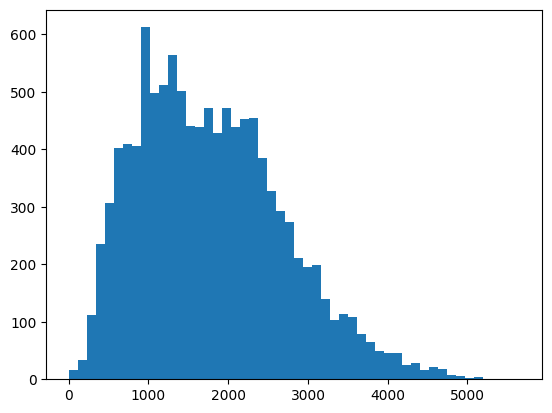

Dist Code                 2
Year                      2
State Code                2
State Name                2
Dist Name                 2
RICE YIELD (Kg per ha)    2
dtype: int64

In [7]:
 # Here we do a quick plot to look at the distribution shape and outliers
plt.hist(crop_target_data[yield_target_col],bins=50)
plt.show()

In [8]:
# join with identifiers_data table for the Latitude and Longitude
identifiers_lat_long = (identifiers_data[["State Code", "District Code", "Latitude", "Longitude"]]
    .rename(columns={"District Code": "Dist Code"}))

# Basically SQL LEFT JOIN
merged_crop_loc = pd.merge(crop_target_data, identifiers_lat_long, on=["State Code", "Dist Code"],
    how="left")

merged_crop_loc.head()

Dist Code  Year  State Code    State Name Dist Name  \
0          1  1980          14  Chhattisgarh      Durg   
1          1  1981          14  Chhattisgarh      Durg   
2          1  1982          14  Chhattisgarh      Durg   
3          1  1983          14  Chhattisgarh      Durg   
4          1  1984          14  Chhattisgarh      Durg   

   RICE YIELD (Kg per ha)  Latitude  Longitude  
0                  812.10      21.2       81.3  
1                  804.60      21.2       81.3  
2                  817.49      21.2       81.3  
3                 1134.51      21.2       81.3  
4                  891.81      21.2       81.3

/usr/local/lib/python3.12/dist-packages/matplotlib/collections.py:1008: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


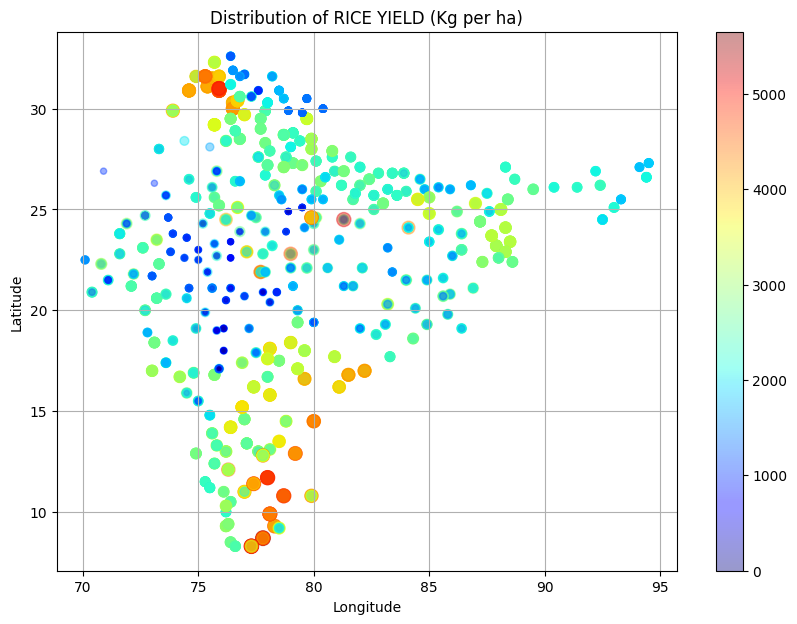

In [9]:
# Plot the geographical information with yield of the crop
# 1 เฮกเตอร์ (Hector) เท่ากับ 6.25  ไร่ หรือเท่ากับ 10,000 ตรม.
# The crop yield is already normalized per hectare from the data source
fig1 = merged_crop_loc.plot(
    kind="scatter",
    x="Longitude",
    y="Latitude",
    title=f"Distribution of {yield_target_col}",
    grid=True,
    s=merged_crop_loc[yield_target_col]/50,
    c=merged_crop_loc[yield_target_col],
    cmap="jet",
    colorbar=True,
    legend=False,
    figsize=(10, 7),
    alpha=0.4
)

/usr/local/lib/python3.12/dist-packages/matplotlib/collections.py:1008: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/local/lib/python3.12/dist-packages/matplotlib/collections.py:1008: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/local/lib/python3.12/dist-packages/matplotlib/collections.py:1008: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/local/lib/python3.12/dist-packages/matplotlib/collections.py:1008: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/local/lib/python3.12/dist-packages/matplotlib/collections.py:1008: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/usr/local/lib/python3.12/dist-packages/matplotlib/collections.py:1008: RuntimeWarning: invalid

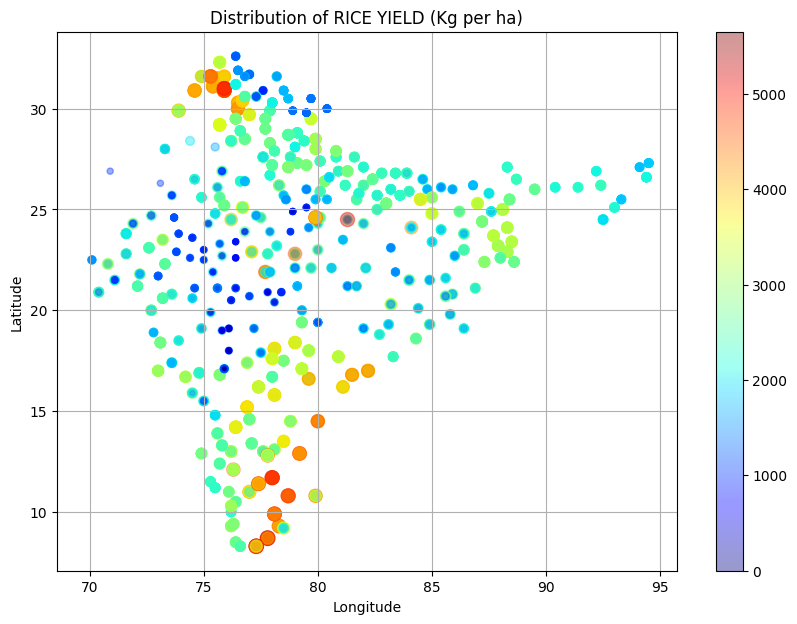

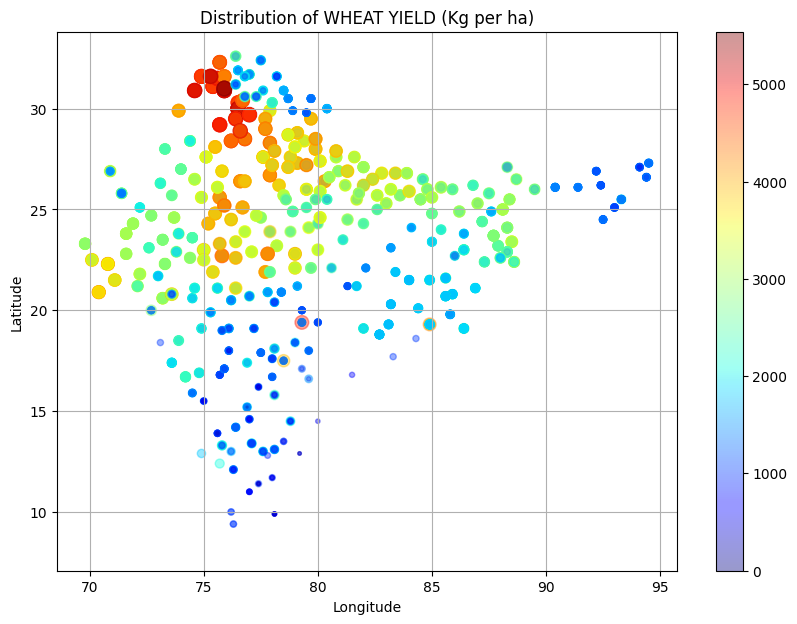

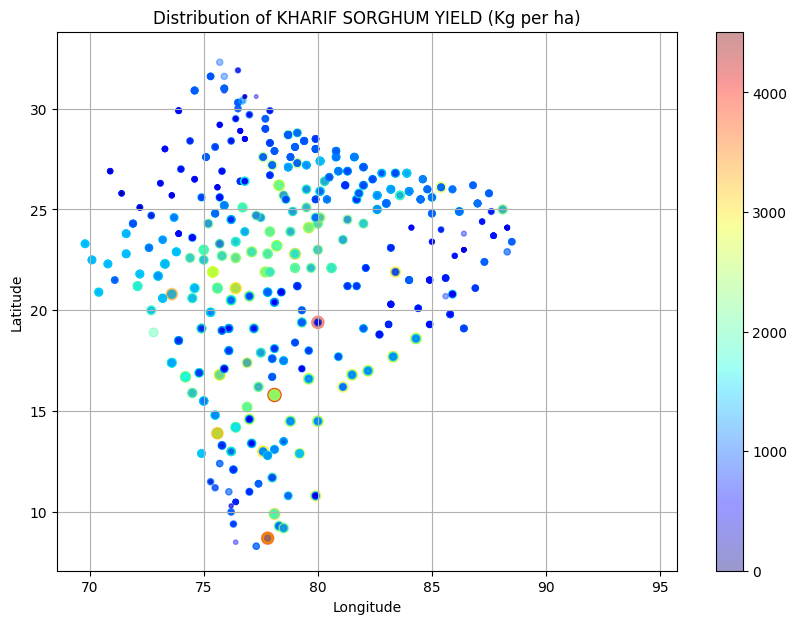

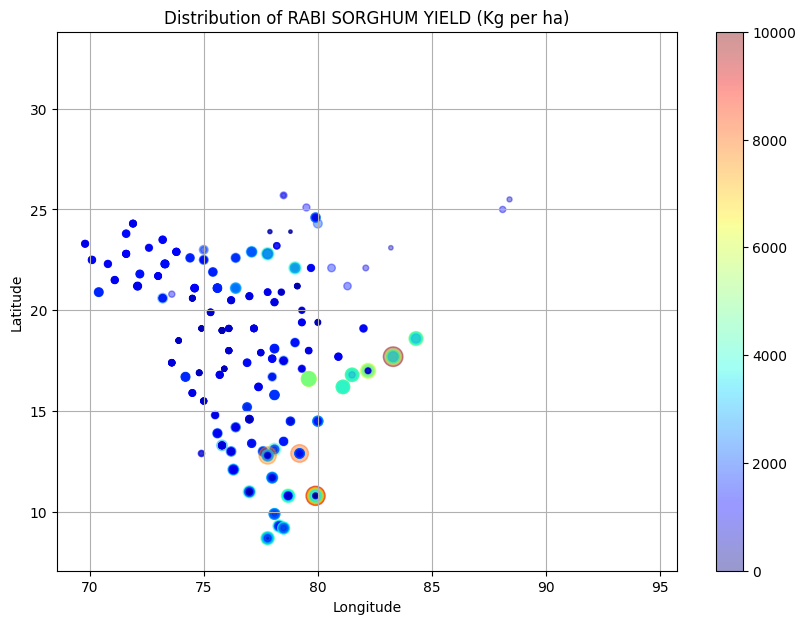

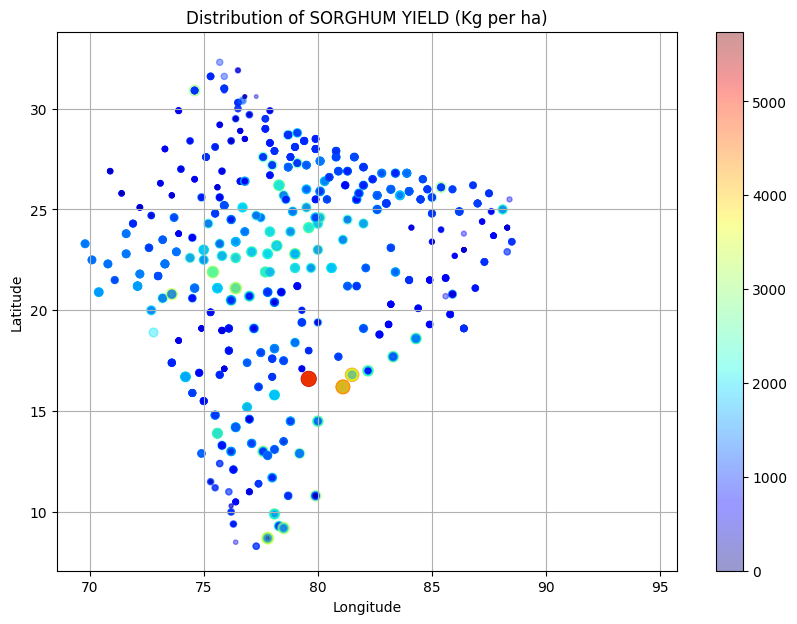

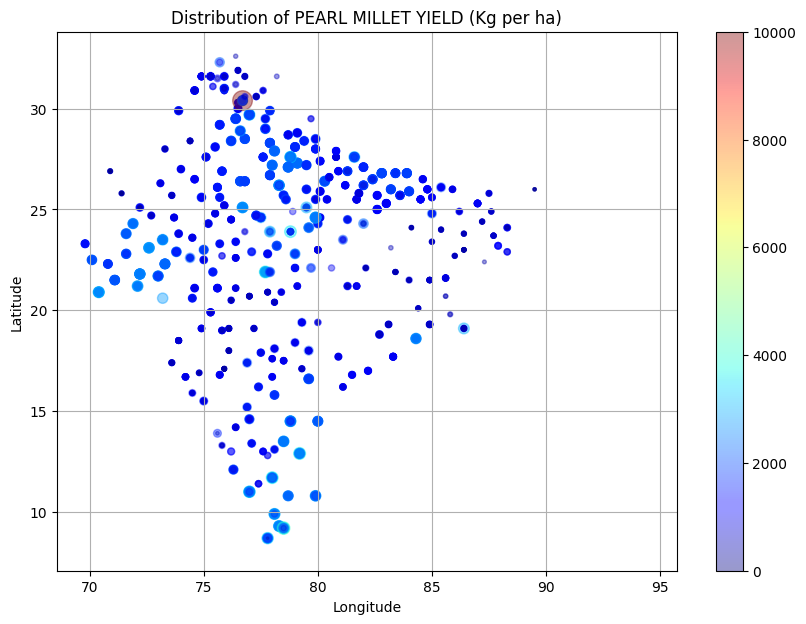

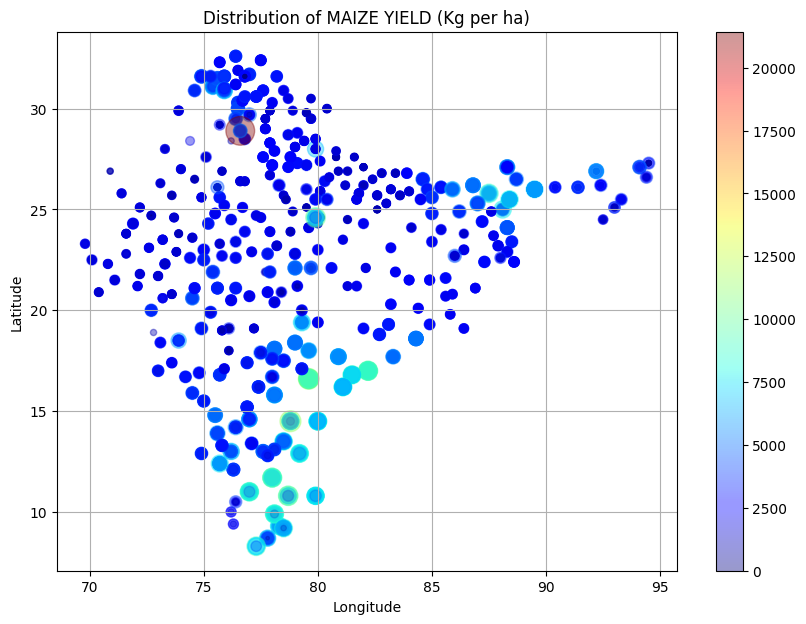

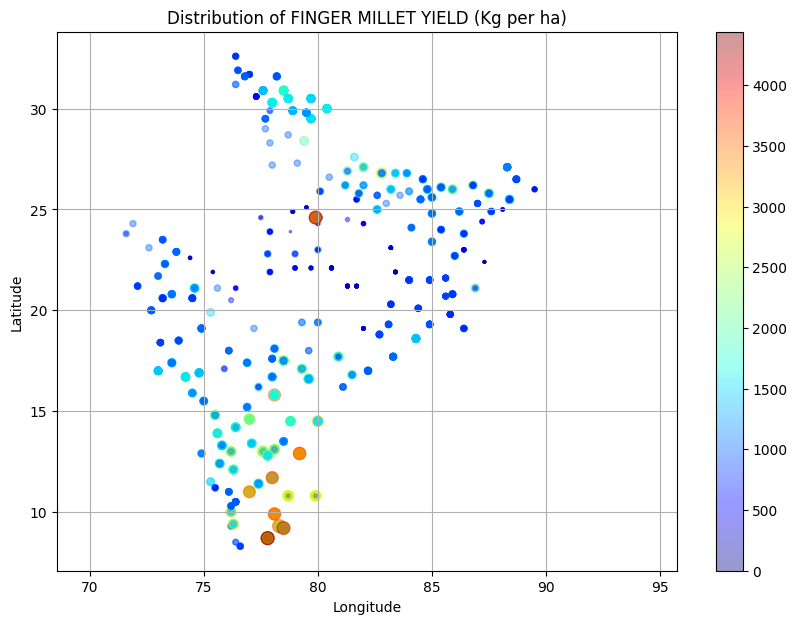

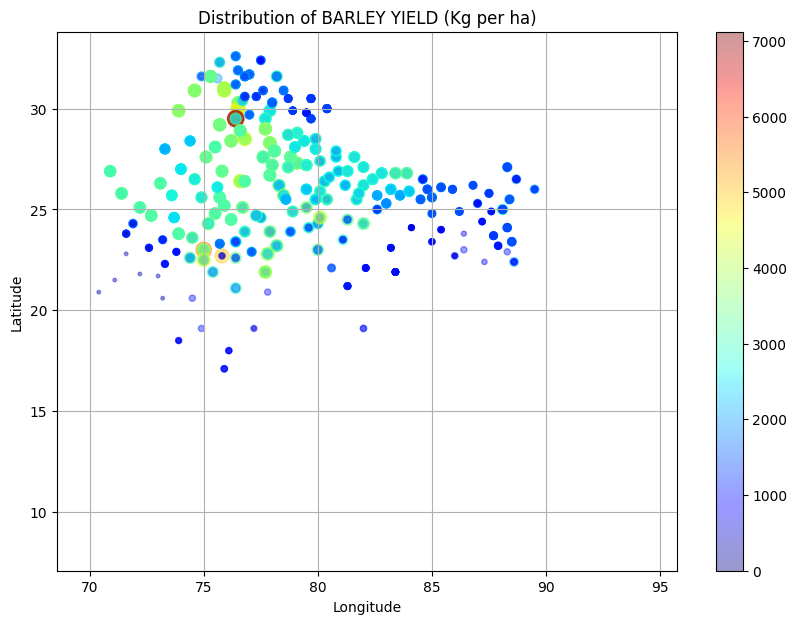

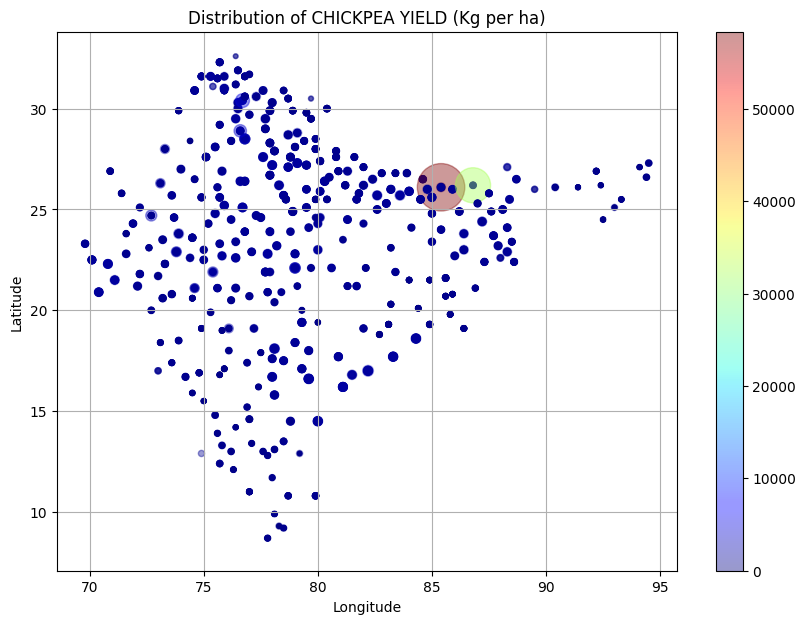

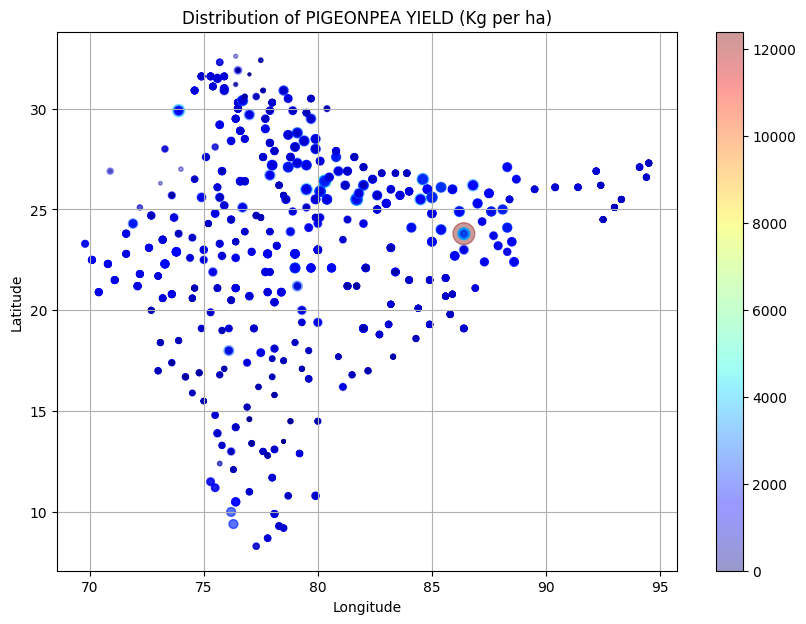

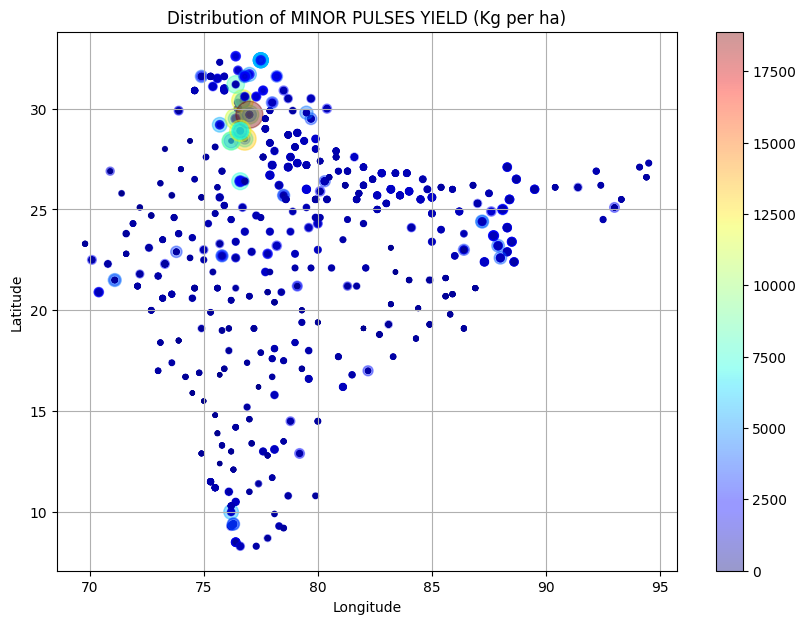

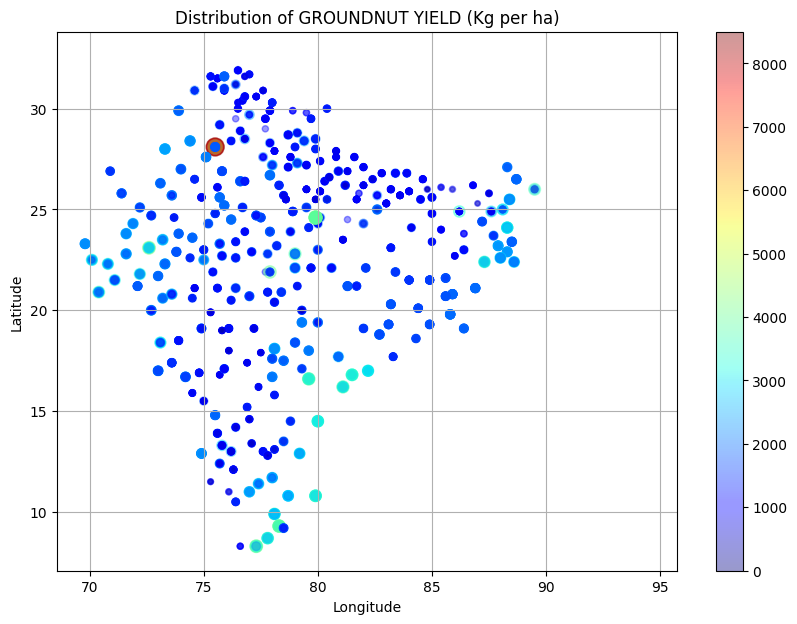

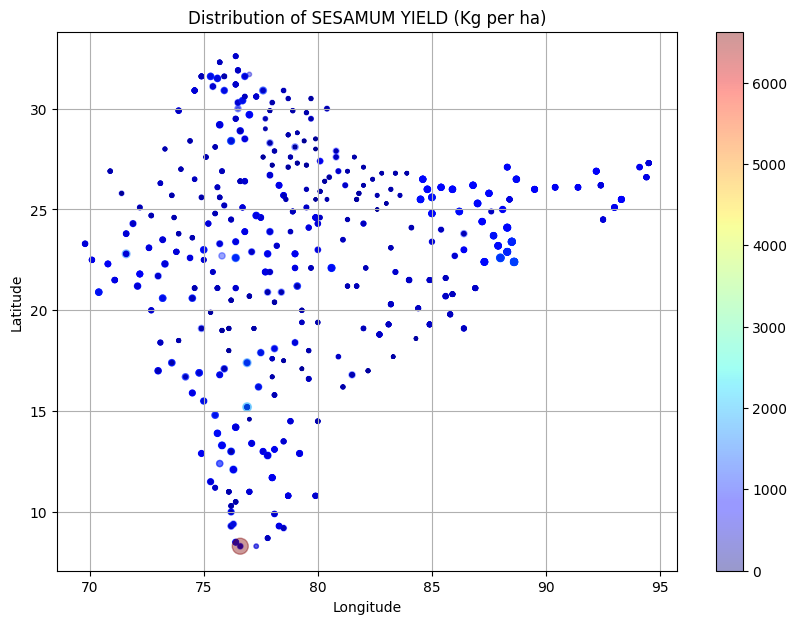

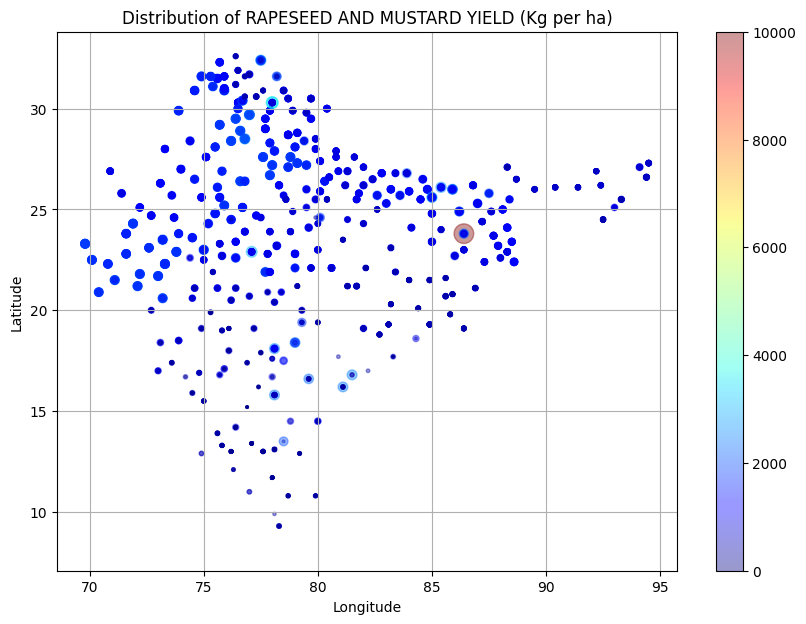

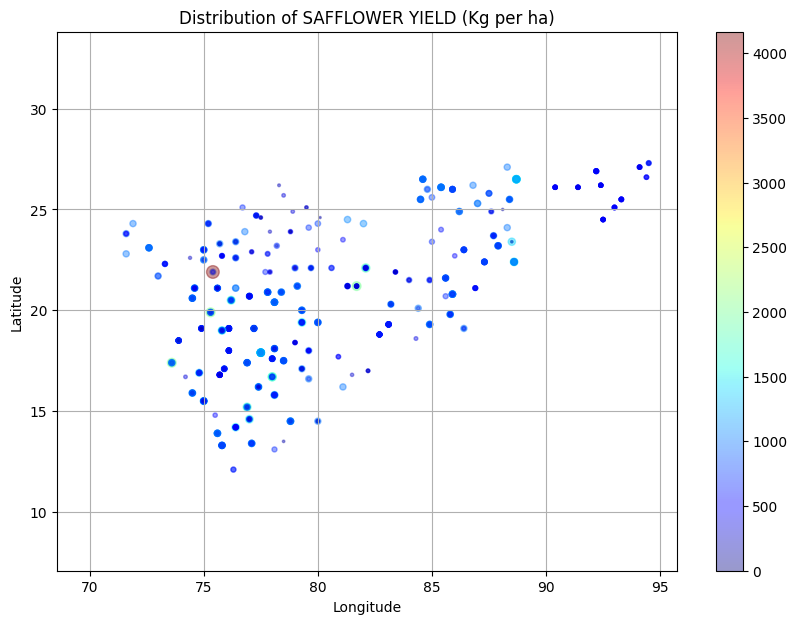

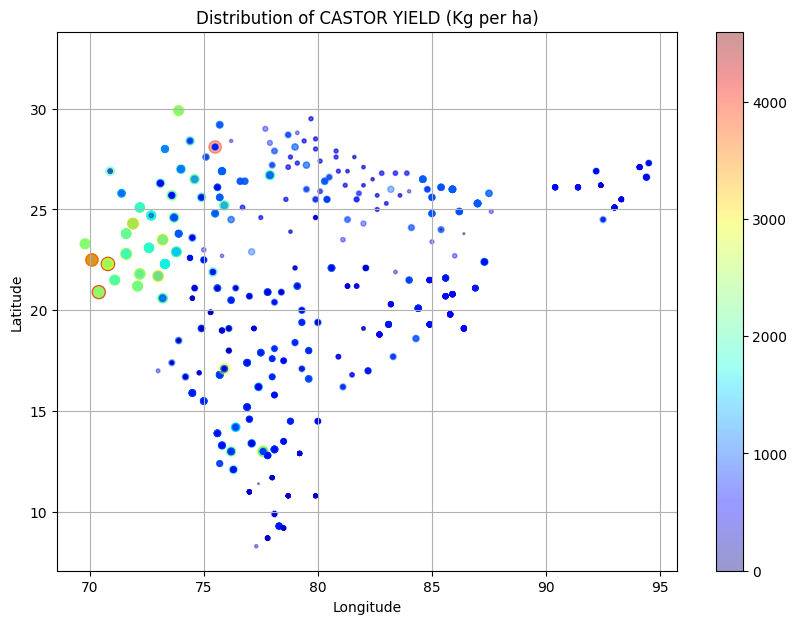

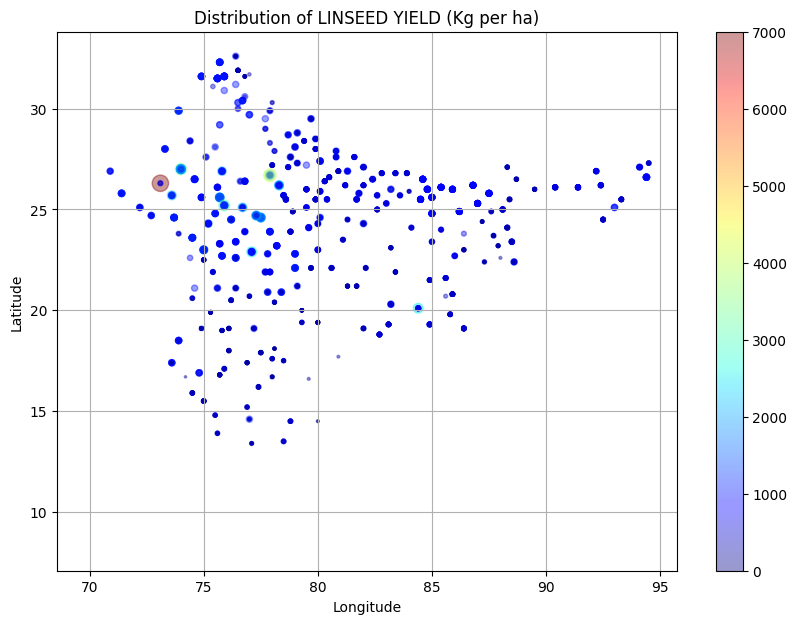

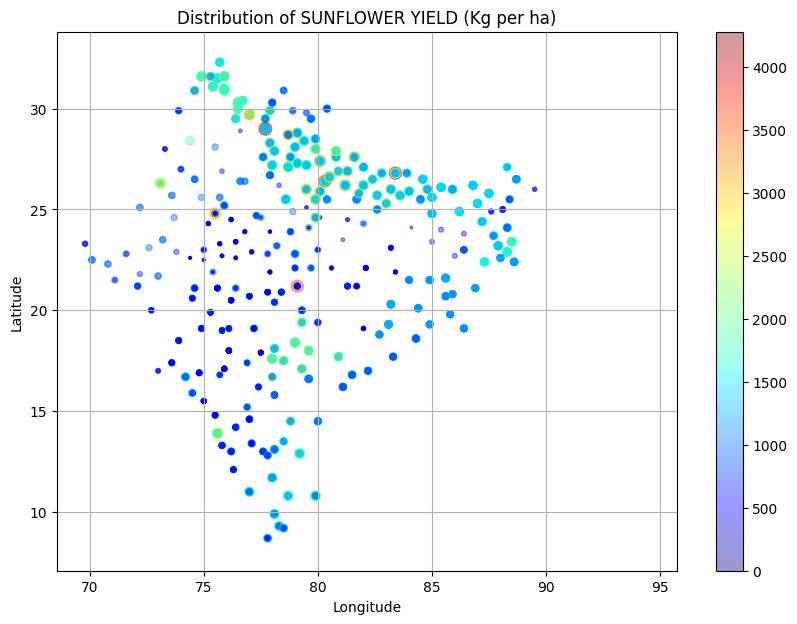

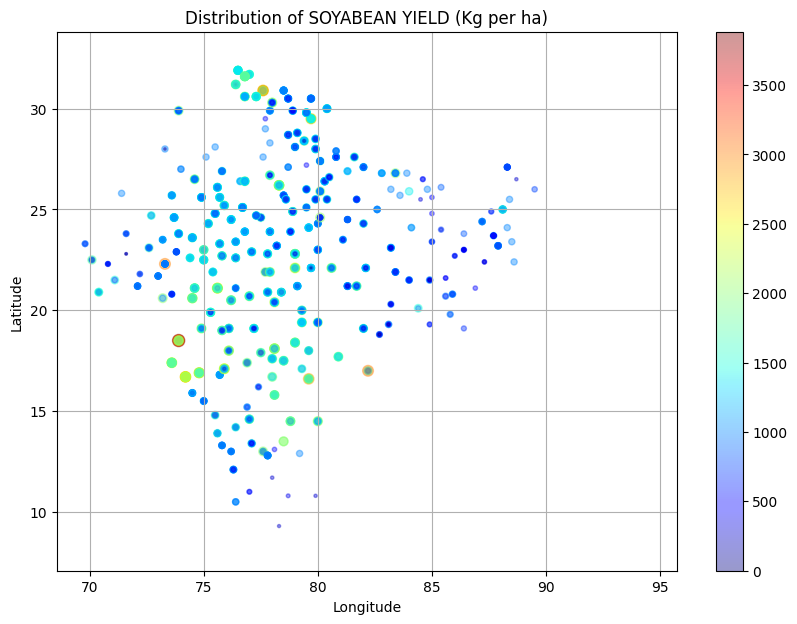

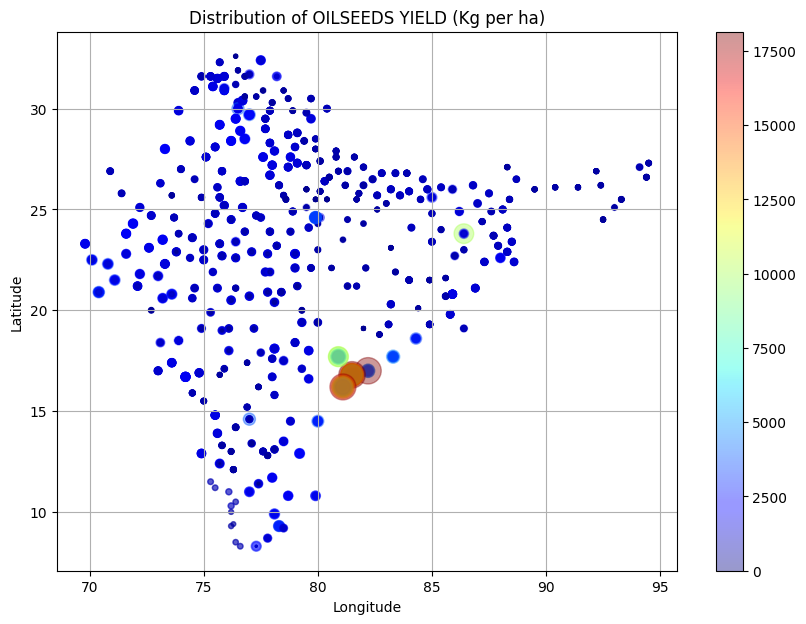

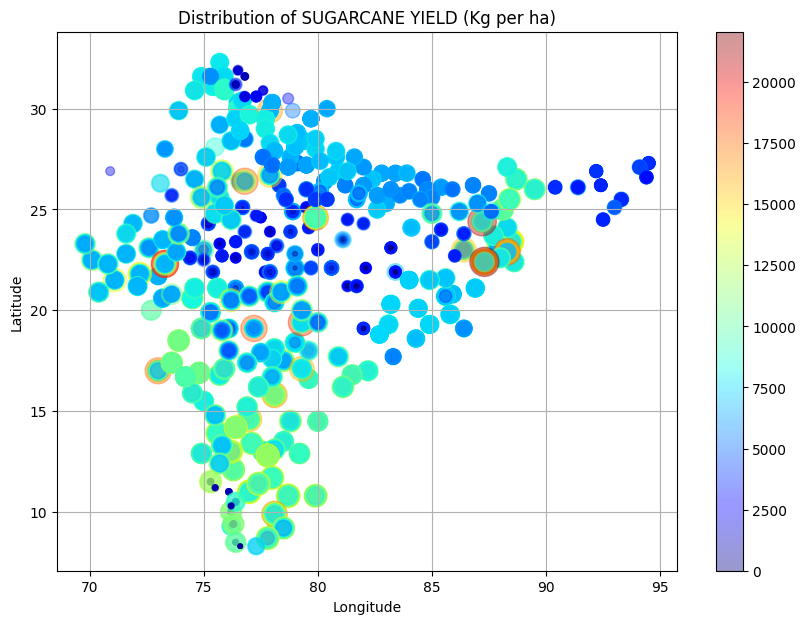

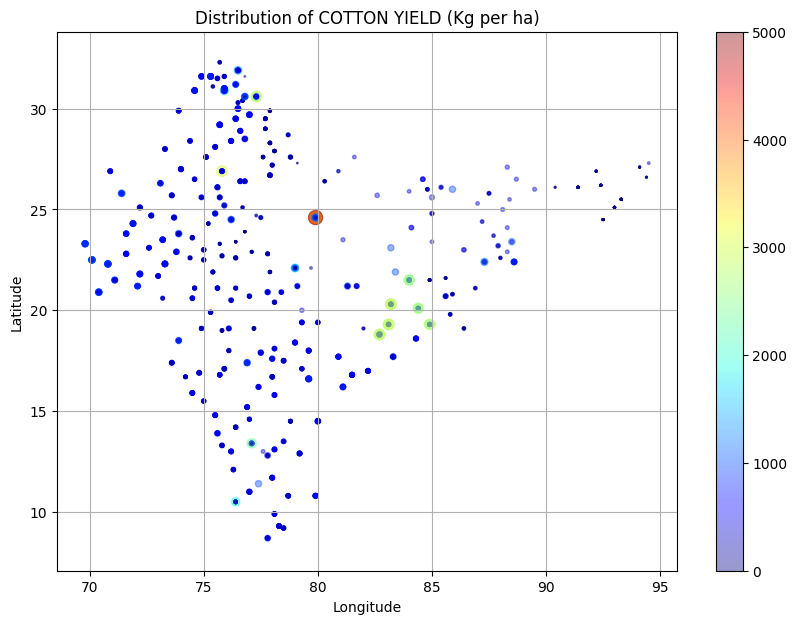

In [10]:
# plot all the crops to observe trend

for crop in available_crop_target_yield:
  crop_target_data_plot = crop_data[identifier_col + [crop]]

  identifiers_lat_long_plot = (identifiers_data[["State Code", "District Code", "Latitude", "Longitude"]]
    .rename(columns={"District Code": "Dist Code"}))

  # Basically SQL LEFT JOIN
  merged_crop_loc_plot = pd.merge(crop_target_data_plot, identifiers_lat_long_plot, on=["State Code", "Dist Code"],
  how="left")

  fig1 = merged_crop_loc_plot.plot(
    kind="scatter",
    x="Longitude",
    y="Latitude",
    title=f"Distribution of {crop}",
    grid=True,
    s=merged_crop_loc_plot[crop]/50,
    c=merged_crop_loc_plot[crop],
    cmap="jet",
    colorbar=True,
    legend=False,
    figsize=(10, 7),
    alpha=0.4
)

In [11]:
print(fertilizer_data.head())

   Dist Code  Year  State Code    State Name Dist Name  \
0          1  1966          14  Chhattisgarh      Durg   
1          1  1967          14  Chhattisgarh      Durg   
2          1  1968          14  Chhattisgarh      Durg   
3          1  1969          14  Chhattisgarh      Durg   
4          1  1970          14  Chhattisgarh      Durg   

   NITROGEN CONSUMPTION (tons)  NITROGEN SHARE IN NPK (Percent)  \
0                       1375.0                            80.74   
1                       1516.0                            78.79   
2                       3042.0                            85.84   
3                       4131.0                            82.39   
4                       4594.0                            67.92   

   NITROGEN PER HA OF NCA (Kg per ha)  NITROGEN PER HA OF GCA (Kg per ha)  \
0                                1.38                                1.27   
1                                1.50                                1.17   
2                

In [12]:
# Choose fertilizdr features to predict yield
fertilizer_data.describe()

# In this project we choose to use kilograms fertilizer per hactares of Gross Cropped Area (GCA) since this attribute is normalized
# (Include multiple cropping, normalized by ha of GCA or land use making it great for comparisons across districts)

available_fertilizer_features_per_HA_GCA = [col for col in fertilizer_data.columns if "GCA" in col]
fertilizer_features_data = fertilizer_data[identifier_col + available_fertilizer_features_per_HA_GCA]

# drop the column 'TOTAL PER HA OF GCA (Kg per ha)' since it is combination of N, P, K fertilizers
fertilizer_features_data.drop(['TOTAL PER HA OF GCA (Kg per ha)'], axis=1, inplace=True)

fertilizer_features_data
# important note: since the features are already in Kg per ha, this is already normalized

/tmp/ipython-input-1361853089.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fertilizer_features_data.drop(['TOTAL PER HA OF GCA (Kg per ha)'], axis=1, inplace=True)


Dist Code  Year  State Code    State Name  Dist Name  \
0              1  1966          14  Chhattisgarh       Durg   
1              1  1967          14  Chhattisgarh       Durg   
2              1  1968          14  Chhattisgarh       Durg   
3              1  1969          14  Chhattisgarh       Durg   
4              1  1970          14  Chhattisgarh       Durg   
...          ...   ...         ...           ...        ...   
16042        917  2013          15     Jharkhand  Singhbhum   
16043        917  2014          15     Jharkhand  Singhbhum   
16044        917  2015          15     Jharkhand  Singhbhum   
16045        917  2016          15     Jharkhand  Singhbhum   
16046        917  2017          15     Jharkhand  Singhbhum   

       NITROGEN PER HA OF GCA (Kg per ha)  \
0                                    1.27   
1                                    1.17   
2                                    2.27   
3                                    3.08   
4                                    3.32   
...                                   ...   
16042                               12.81   
16043                               10.24   
16044                               11.70   
16045                                8.41   
16046                               -1.00   

       PHOSPHATE PER HA OF GCA (Kg per ha)  POTASH PER HA OF GCA (Kg per ha)  
0                                     0.27                              0.03  
1                                     0.16                              0.15  
2                                     0.34                              0.03  
3                                     0.63                              0.03  
4                                     1.46                              0.11  
...                                    ...                               ...  
16042                                 1.32                              0.15  
16043                                 1.14                              0.05  
16044                                 2.83                              0.54  
16045                                 1.78                              0.08  
16046                                -1.00                             -1.00  

[16047 rows x 8 columns]

In [13]:
# Join merged_crop_loc to fertilizer data
merged_crop_fertilizer = pd.merge(merged_crop_loc, fertilizer_features_data,
                     on=["Dist Code","Year","State Code","State Name","Dist Name"],
                     how="left")
merged_crop_fertilizer

Dist Code  Year  State Code    State Name  Dist Name  \
0              1  1980          14  Chhattisgarh       Durg   
1              1  1981          14  Chhattisgarh       Durg   
2              1  1982          14  Chhattisgarh       Durg   
3              1  1983          14  Chhattisgarh       Durg   
4              1  1984          14  Chhattisgarh       Durg   
...          ...   ...         ...           ...        ...   
10956        917  2013          15     Jharkhand  Singhbhum   
10957        917  2014          15     Jharkhand  Singhbhum   
10958        917  2015          15     Jharkhand  Singhbhum   
10959        917  2016          15     Jharkhand  Singhbhum   
10960        917  2017          15     Jharkhand  Singhbhum   

       RICE YIELD (Kg per ha)  Latitude  Longitude  \
0                      812.10      21.2       81.3   
1                      804.60      21.2       81.3   
2                      817.49      21.2       81.3   
3                     1134.51      21.2       81.3   
4                      891.81      21.2       81.3   
...                       ...       ...        ...   
10956                 2170.67      22.7       86.0   
10957                 2288.57      22.7       86.0   
10958                 1005.70      22.7       86.0   
10959                 1423.84      22.7       86.0   
10960                 1731.62      22.7       86.0   

       NITROGEN PER HA OF GCA (Kg per ha)  \
0                                    4.19   
1                                    5.38   
2                                    5.49   
3                                    7.09   
4                                    8.87   
...                                   ...   
10956                               12.81   
10957                               10.24   
10958                               11.70   
10959                                8.41   
10960                               -1.00   

       PHOSPHATE PER HA OF GCA (Kg per ha)  POTASH PER HA OF GCA (Kg per ha)  
0                                     1.89                              0.46  
1                                     3.06                              0.69  
2                                     2.33                              0.62  
3                                     2.95                              0.66  
4                                     4.20                              0.78  
...                                    ...                               ...  
10956                                 1.32                              0.15  
10957                                 1.14                              0.05  
10958                                 2.83                              0.54  
10959                                 1.78                              0.08  
10960                                -1.00                             -1.00  

[10961 rows x 11 columns]

In [14]:
# In this project, we'll be using ANNUAL RAINFALL to generalize the process. However, in agriculture the monthly and seasonal rainfall are far more
# predictive of agriculture yield

print(rainfall_data.head())
rainfall_col = 'ANNUAL RAINFALL (Millimeters)'
rainfall_feature_data = rainfall_data[identifier_col + [rainfall_col]]
merged_crop_fertilizer_rainfall = pd.merge(merged_crop_fertilizer, rainfall_feature_data,
                     on=["Dist Code","Year","State Code","State Name","Dist Name"],
                     how="left")
merged_crop_fertilizer_rainfall

   Dist Code  Year  State Code    State Name Dist Name  \
0          1  1966          14  Chhattisgarh      Durg   
1          1  1967          14  Chhattisgarh      Durg   
2          1  1968          14  Chhattisgarh      Durg   
3          1  1969          14  Chhattisgarh      Durg   
4          1  1970          14  Chhattisgarh      Durg   

   JANUARY RAINFALL (Millimeters)  FEBRUARY RAINFALL (Millimeters)  \
0                             1.4                              0.0   
1                             0.1                              0.0   
2                            27.8                             11.3   
3                             0.6                              0.0   
4                             8.3                              7.9   

   MARCH RAINFALL (Millimeters)  APRIL RAINFALL (Millimeters)  \
0                           0.0                           8.9   
1                          73.4                           0.6   
2                          13.5    

Dist Code  Year  State Code    State Name  Dist Name  \
0              1  1980          14  Chhattisgarh       Durg   
1              1  1981          14  Chhattisgarh       Durg   
2              1  1982          14  Chhattisgarh       Durg   
3              1  1983          14  Chhattisgarh       Durg   
4              1  1984          14  Chhattisgarh       Durg   
...          ...   ...         ...           ...        ...   
10956        917  2013          15     Jharkhand  Singhbhum   
10957        917  2014          15     Jharkhand  Singhbhum   
10958        917  2015          15     Jharkhand  Singhbhum   
10959        917  2016          15     Jharkhand  Singhbhum   
10960        917  2017          15     Jharkhand  Singhbhum   

       RICE YIELD (Kg per ha)  Latitude  Longitude  \
0                      812.10      21.2       81.3   
1                      804.60      21.2       81.3   
2                      817.49      21.2       81.3   
3                     1134.51      21.2       81.3   
4                      891.81      21.2       81.3   
...                       ...       ...        ...   
10956                 2170.67      22.7       86.0   
10957                 2288.57      22.7       86.0   
10958                 1005.70      22.7       86.0   
10959                 1423.84      22.7       86.0   
10960                 1731.62      22.7       86.0   

       NITROGEN PER HA OF GCA (Kg per ha)  \
0                                    4.19   
1                                    5.38   
2                                    5.49   
3                                    7.09   
4                                    8.87   
...                                   ...   
10956                               12.81   
10957                               10.24   
10958                               11.70   
10959                                8.41   
10960                               -1.00   

       PHOSPHATE PER HA OF GCA (Kg per ha)  POTASH PER HA OF GCA (Kg per ha)  \
0                                     1.89                              0.46   
1                                     3.06                              0.69   
2                                     2.33                              0.62   
3                                     2.95                              0.66   
4                                     4.20                              0.78   
...                                    ...                               ...   
10956                                 1.32                              0.15   
10957                                 1.14                              0.05   
10958                                 2.83                              0.54   
10959                                 1.78                              0.08   
10960                                -1.00                             -1.00   

       ANNUAL RAINFALL (Millimeters)  
0                             1357.3  
1                              947.6  
2                              841.6  
3                             1073.2  
4                             1102.2  
...                              ...  
10956                         1626.4  
10957                         1431.2  
10958                         1158.4  
10959                            NaN  
10960                            NaN  

[10961 rows x 12 columns]

In [15]:
print(soil_data.head(),'\n')
print(soil_data.info())
print(soil_data["SOIL TYPE PERCENT (Percent)"].unique())

soil_data.dropna(axis=0, inplace=True)
"""
From soil_data["SOIL TYPE PERCENT (Percent)"], the data type is object, with
310 non-null values out of 313, meaning there are 3 NA values.

In addition, most records include percentage information; however, some do not,
such as:
'USTALFS-OCHREPTS', 'UDALFS', 'UDALFS-OCHREPTS', nan,
'PSAMMENTS-OCHREPTS', 'FLUVENTS-ORTHENTS', 'PSAMMENTS-ORTHENTS',
'USTALFS-TROPEPTS', 'ORTHENTS-TROPEPTS', 'DYSTROPEPTS-ORTHENTS'.

In cases where domain expertise is available (e.g., soil scientists), their input
would typically be use to guide data simplification.

For this project, soil types and their associated percentage values are encoded
as separate columns. However, the input data are not fully standardized; some
entries include explicit percentages (e.g., 'ORTHIDS - 85%; VERTI SOLS - 15%'),
while others list multiple soil types separated by dash or slash (e.g., 'USTALFS-OCHREPTS'
or 'UDOLLS/UDALFS - 100%') the percentage will be evently split.

Moreover, soil classifications appear at the sub-group level. Therefore, in this
project, these classifications are simplified to their corresponding broad soil
classes. Their main class is mapped using the soil_map dictionary.
"""

   Dist Code            Year  State Code    State Name Dist Name  \
0          1  Not Applicable          14  Chhattisgarh      Durg   
1          2  Not Applicable          14  Chhattisgarh    Bastar   
2          3  Not Applicable          14  Chhattisgarh    Raipur   
3          4  Not Applicable          14  Chhattisgarh  Bilaspur   
4          5  Not Applicable          14  Chhattisgarh   Raigarh   

                         SOIL TYPE PERCENT (Percent)  
0        LOAMY ALFISOLS - 60% ; USTALF/USTOLLS - 40%  
1                               LOAMY ALFISOL - 100%  
2  USTALF/USTOLLS - 50% ; LOAMY ALFISOLS - 25% ; ...  
3                              USTALF/USTOLLS - 100%  
4                              USTALF/USTOLLS - 100%   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313 entries, 0 to 312
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Dist Code                    313 non

'\nFrom soil_data["SOIL TYPE PERCENT (Percent)"], the data type is object, with\n310 non-null values out of 313, meaning there are 3 NA values.\n\nIn addition, most records include percentage information; however, some do not,\nsuch as:\n\'USTALFS-OCHREPTS\', \'UDALFS\', \'UDALFS-OCHREPTS\', nan,\n\'PSAMMENTS-OCHREPTS\', \'FLUVENTS-ORTHENTS\', \'PSAMMENTS-ORTHENTS\',\n\'USTALFS-TROPEPTS\', \'ORTHENTS-TROPEPTS\', \'DYSTROPEPTS-ORTHENTS\'.\n\nIn cases where domain expertise is available (e.g., soil scientists), their input\nwould typically be use to guide data simplification.\n\nFor this project, soil types and their associated percentage values are encoded\nas separate columns. However, the input data are not fully standardized; some\nentries include explicit percentages (e.g., \'ORTHIDS - 85%; VERTI SOLS - 15%\'),\nwhile others list multiple soil types separated by dash or slash (e.g., \'USTALFS-OCHREPTS\'\nor \'UDOLLS/UDALFS - 100%\') the percentage will be evently split.\n\nMoreover,

In [16]:
soil_map = {
    # Mollisols
    "UDOLLS": "MOLLISOLS",
    "USTOLLS": "MOLLISOLS",

    # Alfisols
    "USTALF": "ALFISOLS",
    "USTALFS": "ALFISOLS",
    "UDALFS": "ALFISOLS",
    "LOAMY ALFISOLS": "ALFISOLS",
    "LOAMY ALFISOL": "ALFISOLS",
    "SANDY ALFISOL": "ALFISOLS",
    "SANDY ALFISOLS": "ALFISOLS",

    # Vertisols
    "VERTISOLS": "VERTISOLS",
    "VERTIC SOILS": "VERTISOLS",
    "VERTIC SOLS": "VERTISOLS",
    "VERRTISOLS": "VERTISOLS",
    "VRTIC SOILS": "VERTISOLS",
    "VERTIC OSILS": "VERTISOLS",
    "VERTI SOLS": "VERTISOLS",

    # Aridisols
    "ORTHIDS": "ARIDISOLS",

    # Inceptisols
    "INCEPTISOLS": "INCEPTISOLS",
    "INNCEPTISOLS": "INCEPTISOLS",
    "TROPEPTS": "INCEPTISOLS",
    "OCHREPTS": "INCEPTISOLS",
    "UDUPTS": "INCEPTISOLS",
    "DYSTROPEPTS": "INCEPTISOLS",

    # Entisols
    "PSAMMENTS": "ENTISOLS",
    "PSSAMENTS": "ENTISOLS",
    "PSSAMNETS": "ENTISOLS",
    "ORTHENTS": "ENTISOLS",
    "FLUVENTS": "ENTISOLS",
}

soil_final_list = sorted(set(soil_map.values()))

In [17]:
# create custom transformer for transforming the soil type percentage into their columns

class SoilCompositionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def _parse_cell(self, cell):
        """
        Parse a soil composition cell into proportional contributions for main soil classes.
        Rules:
        - Percentage-based mixtures use the percentage value
        - Slash ("/") type are split evenly to their class
        - Dash ("-") type are split evenly to their class
        """
        result = {soil: 0.0 for soil in soil_final_list}

        if pd.isna(cell):
            return result

        cell = str(cell).upper()
        cell = re.sub(r"\s+", " ", cell).strip()

        if cell in ("NA", ""):
            return result

        # percentage-based
        if "%" in cell:
            for part in cell.split(";"):
                part = part.strip()
                match = re.search(
                    r"(.+?)\s-\s(\d+(?:\.\d+)?)%?",
                    part
                )
                if not match:
                    continue

                soil_raw, pct_str = match.groups()
                pct = float(pct_str)

                tokens = [
                    t.strip()
                    for t in re.split(r"[/-]", soil_raw)
                    if t.strip()
                ]

                weight = pct / len(tokens)

                for token in tokens:
                    if token in soil_map:
                        result[soil_map[token]] += weight

            return result

        # no percentages
        if "/" in cell or "-" in cell:
            tokens = [
                t.strip()
                for t in re.split(r"[/-]", cell)
                if t.strip()
            ]

            weight = 100 / len(tokens)

            for token in tokens:
                if token in soil_map:
                    result[soil_map[token]] += weight

        return result

    def transform(self, X):
        parsed = X[self.column].apply(self._parse_cell)
        return pd.DataFrame(parsed.tolist(), index=X.index)


In [18]:
ct = ColumnTransformer(
    transformers=[
        (
            "soil",
            SoilCompositionTransformer("SOIL TYPE PERCENT (Percent)"),
            ["SOIL TYPE PERCENT (Percent)"]
        )
    ],
    remainder="drop")

soil_data_soil_type = ct.fit_transform(soil_data)

# Wrap into DataFrame with soil features
soil_data_soil_type = pd.DataFrame(
    soil_data_soil_type,
    columns=soil_final_list,
    index=soil_data.index
)

# Concatenate identifier columns back
soil_data_transformed = pd.concat(
    [soil_data[["Dist Code", "State Code", "State Name", "Dist Name"]], soil_data_soil_type],
    axis=1
)

print(soil_data_transformed.head())

   Dist Code  State Code    State Name Dist Name  ALFISOLS  ARIDISOLS  \
0          1          14  Chhattisgarh      Durg      80.0        0.0   
1          2          14  Chhattisgarh    Bastar     100.0        0.0   
2          3          14  Chhattisgarh    Raipur      50.0        0.0   
3          4          14  Chhattisgarh  Bilaspur      50.0        0.0   
4          5          14  Chhattisgarh   Raigarh      50.0        0.0   

   ENTISOLS  INCEPTISOLS  MOLLISOLS  VERTISOLS  
0       0.0          0.0       20.0        0.0  
1       0.0          0.0        0.0        0.0  
2       0.0          0.0       25.0       15.0  
3       0.0          0.0       50.0        0.0  
4       0.0          0.0       50.0        0.0  


In [19]:
# merge soil type to make full dataframe and drop identifiers
full_merge_df = pd.merge(merged_crop_fertilizer_rainfall, soil_data_transformed,
                     on=['Dist Code', 'State Code', 'State Name', 'Dist Name'],
                     how='left')

# full_merge_df.drop(['Dist Code', 'Year', 'State Code', 'State Name', 'Dist Name'],axis=1,inplace=True)
full_merge_df

Dist Code  Year  State Code    State Name  Dist Name  \
0              1  1980          14  Chhattisgarh       Durg   
1              1  1981          14  Chhattisgarh       Durg   
2              1  1982          14  Chhattisgarh       Durg   
3              1  1983          14  Chhattisgarh       Durg   
4              1  1984          14  Chhattisgarh       Durg   
...          ...   ...         ...           ...        ...   
10956        917  2013          15     Jharkhand  Singhbhum   
10957        917  2014          15     Jharkhand  Singhbhum   
10958        917  2015          15     Jharkhand  Singhbhum   
10959        917  2016          15     Jharkhand  Singhbhum   
10960        917  2017          15     Jharkhand  Singhbhum   

       RICE YIELD (Kg per ha)  Latitude  Longitude  \
0                      812.10      21.2       81.3   
1                      804.60      21.2       81.3   
2                      817.49      21.2       81.3   
3                     1134.51      21.2       81.3   
4                      891.81      21.2       81.3   
...                       ...       ...        ...   
10956                 2170.67      22.7       86.0   
10957                 2288.57      22.7       86.0   
10958                 1005.70      22.7       86.0   
10959                 1423.84      22.7       86.0   
10960                 1731.62      22.7       86.0   

       NITROGEN PER HA OF GCA (Kg per ha)  \
0                                    4.19   
1                                    5.38   
2                                    5.49   
3                                    7.09   
4                                    8.87   
...                                   ...   
10956                               12.81   
10957                               10.24   
10958                               11.70   
10959                                8.41   
10960                               -1.00   

       PHOSPHATE PER HA OF GCA (Kg per ha)  POTASH PER HA OF GCA (Kg per ha)  \
0                                     1.89                              0.46   
1                                     3.06                              0.69   
2                                     2.33                              0.62   
3                                     2.95                              0.66   
4                                     4.20                              0.78   
...                                    ...                               ...   
10956                                 1.32                              0.15   
10957                                 1.14                              0.05   
10958                                 2.83                              0.54   
10959                                 1.78                              0.08   
10960                                -1.00                             -1.00   

       ANNUAL RAINFALL (Millimeters)  ALFISOLS  ARIDISOLS  ENTISOLS  \
0                             1357.3      80.0        0.0       0.0   
1                              947.6      80.0        0.0       0.0   
2                              841.6      80.0        0.0       0.0   
3                             1073.2      80.0        0.0       0.0   
4                             1102.2      80.0        0.0       0.0   
...                              ...       ...        ...       ...   
10956                         1626.4      50.0        0.0       0.0   
10957                         1431.2      50.0        0.0       0.0   
10958                         1158.4      50.0        0.0       0.0   
10959                            NaN      50.0        0.0       0.0   
10960                            NaN      50.0        0.0       0.0   

       INCEPTISOLS  MOLLISOLS  VERTISOLS  
0              0.0       20.0        0.0  
1              0.0       20.0        0.0  
2              0.0       20.0        0.0  
3              0.0       20.0        0.0  
4              0.0       20.0  

/usr/local/lib/python3.12/dist-packages/matplotlib/collections.py:1008: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/tmp/ipython-input-3016203923.py:22: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  dominant_merged_crop_fertilizer_soil["Dominant_Soil"] = full_merge_df[soil_final_list].idxmax(axis=1)
/usr/local/lib/python3.12/dist-packages/matplotlib/collections.py:1008: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


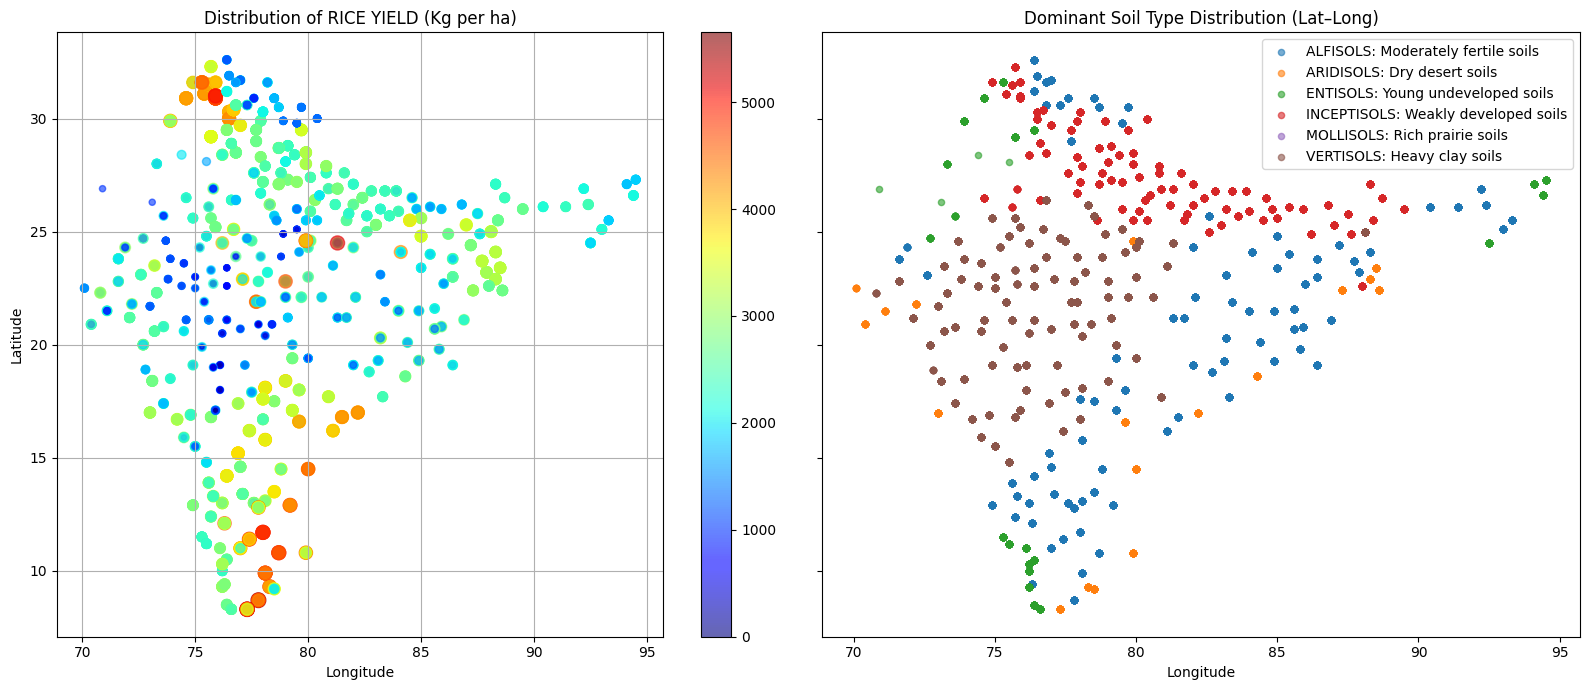

In [20]:
# create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 7),sharey=True)

# Left subplot: yield distribution
full_merge_df.plot(
    kind="scatter",
    x="Longitude",
    y="Latitude",
    title=f"Distribution of {yield_target_col}",
    grid=True,
    s=full_merge_df[yield_target_col]/50,
    c=full_merge_df[yield_target_col],
    cmap="jet",
    colorbar=True,
    legend=False,
    alpha=0.6,
    ax=axes[0]   # plot on left axis
)

# Right subplot: dominant soil type distribution
dominant_merged_crop_fertilizer_soil = full_merge_df.copy()
dominant_merged_crop_fertilizer_soil["Dominant_Soil"] = full_merge_df[soil_final_list].idxmax(axis=1)

soil_short_definition = {
    "ALFISOLS": "Moderately fertile soils",
    "ARIDISOLS": "Dry desert soils",
    "ENTISOLS": "Young undeveloped soils",
    "INCEPTISOLS": "Weakly developed soils",
    "MOLLISOLS": "Rich prairie soils",
    "VERTISOLS": "Heavy clay soils"
}

for soil in soil_final_list:
    subset = dominant_merged_crop_fertilizer_soil[
        dominant_merged_crop_fertilizer_soil["Dominant_Soil"] == soil
    ]
    axes[1].scatter(
        subset["Longitude"],
        subset["Latitude"],
        label=f"{soil}: {soil_short_definition[soil]}",
        alpha=0.6,
        s=20
    )

axes[1].set_title("Dominant Soil Type Distribution (Lat–Long)")
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")
axes[1].legend()

plt.tight_layout()
plt.show()
# observe on soil type and yield value

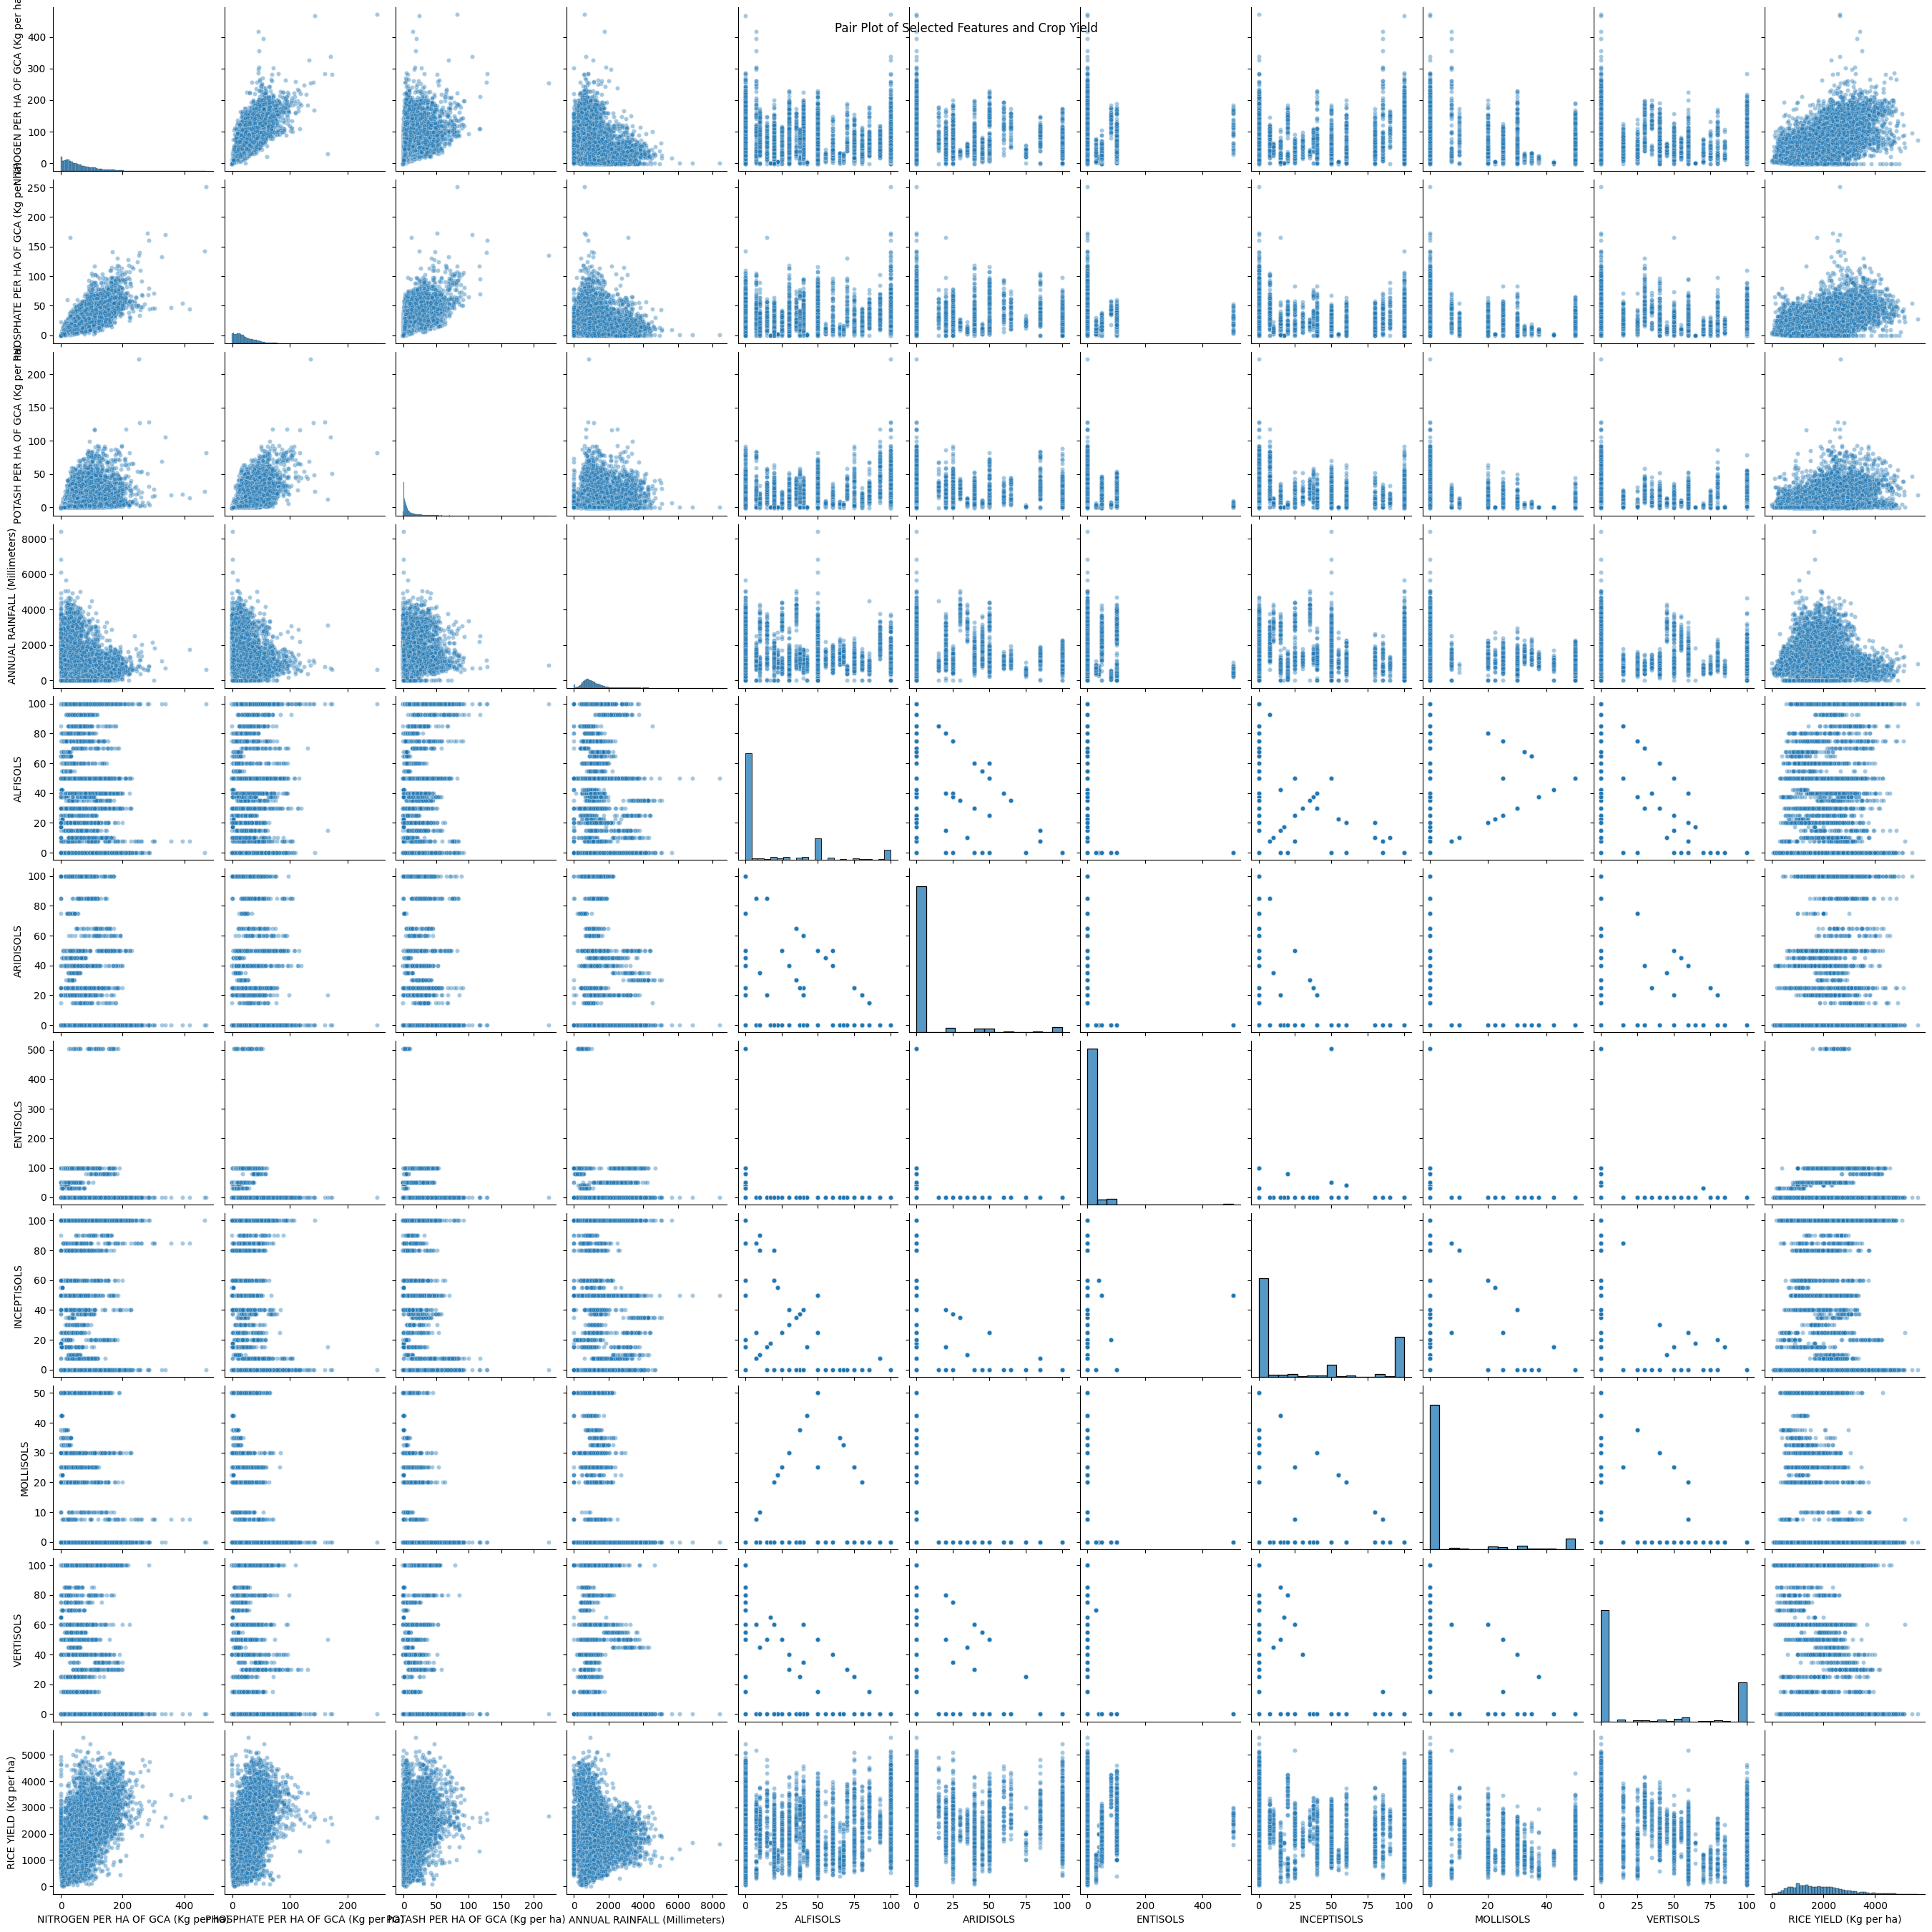

'\nNote that the correlation coefficient only measures linear correlations\n\nFor rice yield, we observe a positive correlation with nitrogen fertilizer usage,\nfollowed by potash. Soil types show different correlation patterns: ALFISOLS,\nARIDISOLS, and INCEPTISOLS exhibit weak positive correlations, while VERTISOLS\nshow a negative correlation. It is important to note that these relationships\nreflect statistical associations only. Yield differences across soil types may\nalso be influenced by local cultivation practices, irrigation, or fertilizer\ninvestment, rather than soil type alone.\n\n'

In [21]:
attributes = ['NITROGEN PER HA OF GCA (Kg per ha)',  'PHOSPHATE PER HA OF GCA (Kg per ha)',
            'POTASH PER HA OF GCA (Kg per ha)', 'ANNUAL RAINFALL (Millimeters)',  'ALFISOLS',  'ARIDISOLS', 'ENTISOLS', 'INCEPTISOLS',
             'MOLLISOLS', 'VERTISOLS'] + [yield_target_col] #'Latitude',  'Longitude'

sns.pairplot(full_merge_df[attributes],
             plot_kws={'alpha':0.4, 's':20})
plt.suptitle('Pair Plot of Selected Features and Crop Yield')
plt.show()

"""
Note that the correlation coefficient only measures linear correlations

For rice yield, we observe a positive correlation with nitrogen fertilizer usage,
followed by potash. Soil types show different correlation patterns: ALFISOLS,
ARIDISOLS, and INCEPTISOLS exhibit weak positive correlations, while VERTISOLS
show a negative correlation. It is important to note that these relationships
reflect statistical associations only. Yield differences across soil types may
also be influenced by local cultivation practices, irrigation, or fertilizer
investment, rather than soil type alone.

"""

In [22]:
corr_matrix = full_merge_df[attributes].corr()
corr_matrix[yield_target_col].sort_values(ascending=False)

RICE YIELD (Kg per ha)                 1.000000
NITROGEN PER HA OF GCA (Kg per ha)     0.613869
PHOSPHATE PER HA OF GCA (Kg per ha)    0.546074
POTASH PER HA OF GCA (Kg per ha)       0.425089
ALFISOLS                               0.225827
ARIDISOLS                              0.206806
INCEPTISOLS                            0.143540
ENTISOLS                               0.096852
ANNUAL RAINFALL (Millimeters)         -0.024732
MOLLISOLS                             -0.139712
VERTISOLS                             -0.399099
Name: RICE YIELD (Kg per ha), dtype: float64

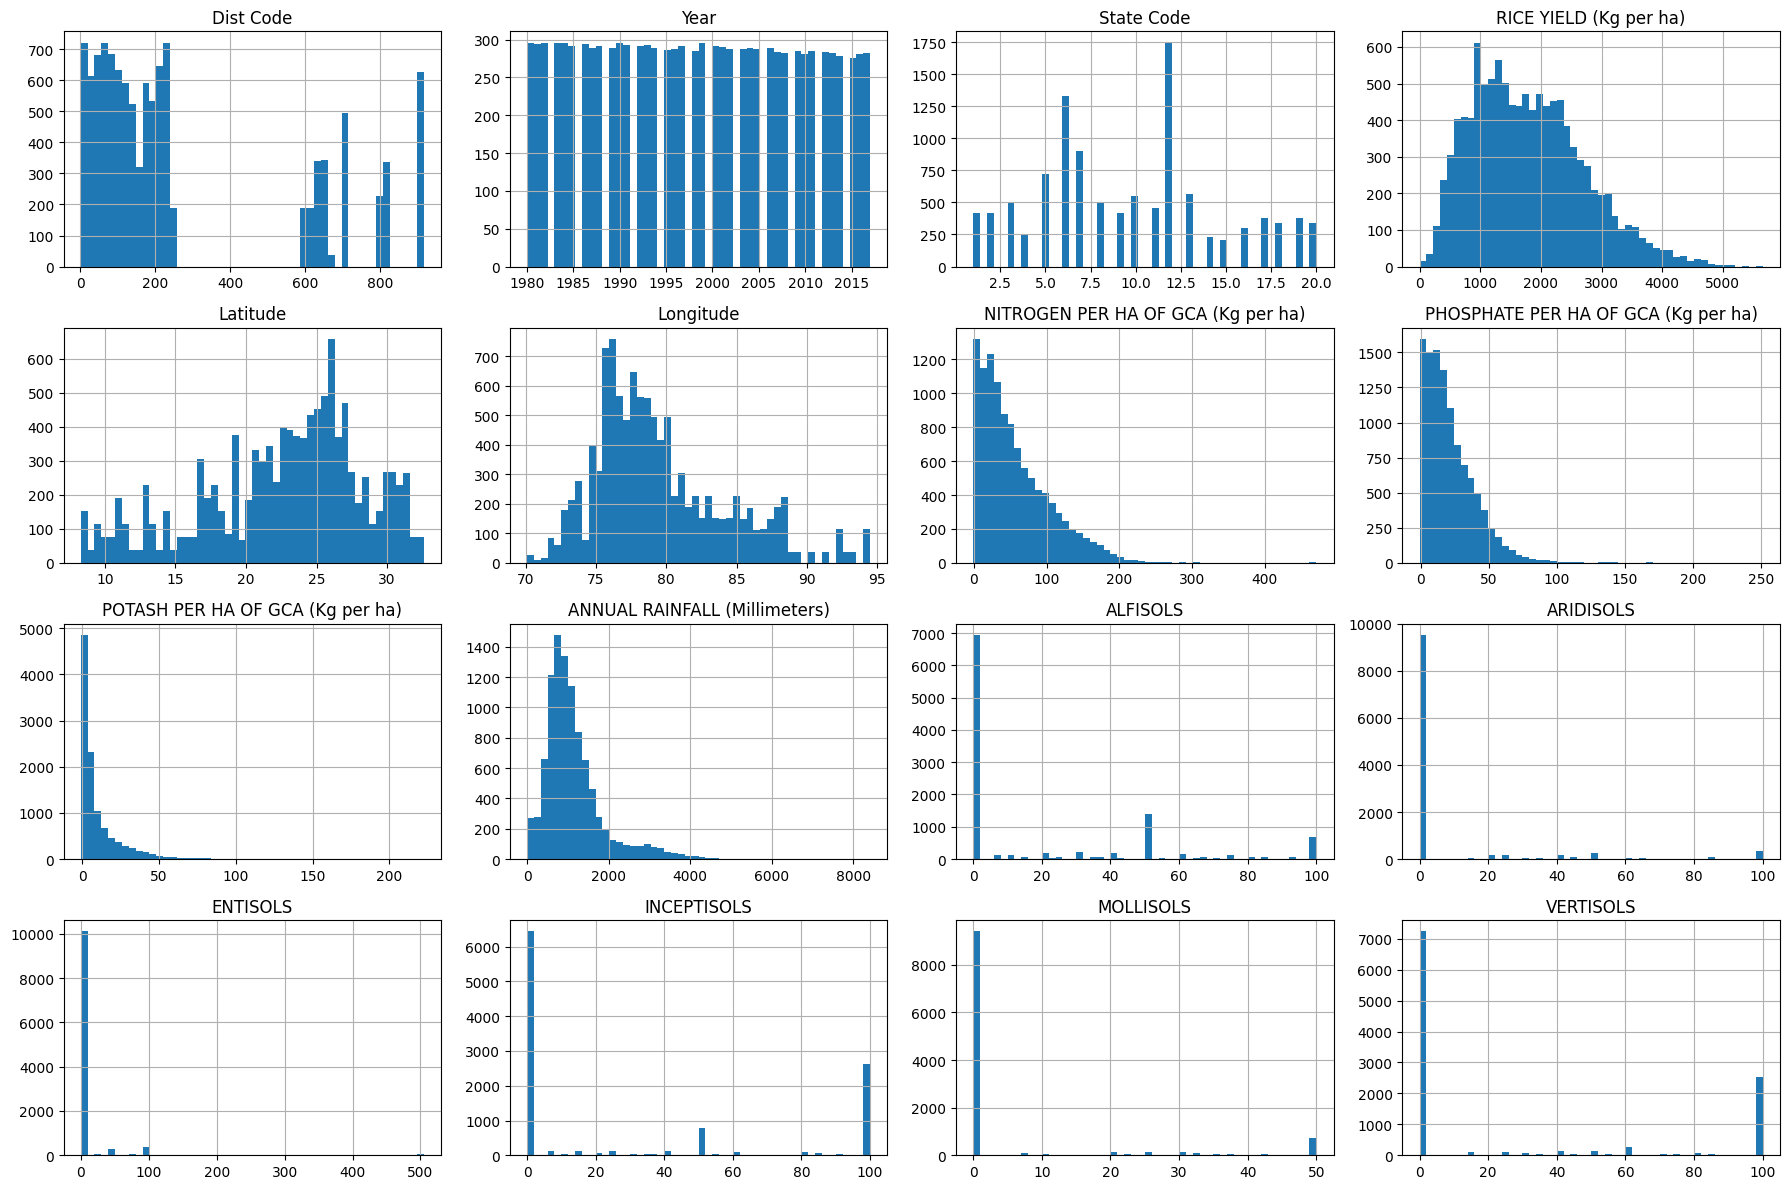

In [23]:
full_merge_df.hist(bins=50, figsize=(18, 12))
plt.tight_layout()
plt.show()

Looking at these histograms, we noticed that some of the attributes are skewed right (they extend much farther to the
right of the median than to the left) This may make it a bit harder for some
ML algorithms to detect patterns. We'll try transforming
these attributes to have more symmetrical and bell-shaped distributions in the pipeline.

# Preprocessing steps

 Before we do any preprocessing steps, we need to split our data into training and testing sets. Since in this project, we do have year as our time line. We will be doing time-based spliting from 1980 to 2010 for training set and 2011-2017 for testing set.

 Which will be roughly 80-20 train-test split.

In [24]:
full_merge_df.describe()
# notice that there are -1 value in our target variable, we need to clean this before
# for the features, we'll be cleaning using pipeline

Dist Code          Year    State Code  RICE YIELD (Kg per ha)  \
count  10961.000000  10961.000000  10961.000000            10961.000000   
mean     277.908311   1998.326156      9.678223             1791.949207   
std      284.643621     10.952364      5.062205              915.543558   
min        1.000000   1980.000000      1.000000               -1.000000   
25%       75.000000   1989.000000      6.000000             1064.940000   
50%      165.000000   1998.000000     10.000000             1694.820000   
75%      602.000000   2008.000000     13.000000             2380.490000   
max      917.000000   2017.000000     20.000000             5653.830000   

           Latitude     Longitude  NITROGEN PER HA OF GCA (Kg per ha)  \
count  10961.000000  10961.000000                        10942.000000   
mean      22.632953     79.581379                           57.156692   
std        5.763307      4.760349                           48.866706   
min        8.300000     70.100000                           -1.000000   
25%       19.100000     76.300000                           20.015000   
50%       23.800000     78.500000                           44.150000   
75%       26.500000     82.000000                           83.837500   
max       32.600000     94.500000                          470.970000   

       PHOSPHATE PER HA OF GCA (Kg per ha)  POTASH PER HA OF GCA (Kg per ha)  \
count                         10942.000000                      10942.000000   
mean                             21.574509                          9.795502   
std                              18.489966                         13.864701   
min                              -1.000000                         -1.000000   
25%                               7.910000                          1.220000   
50%                              17.160000                          4.320000   
75%                              31.187500                         12.340000   
max                             251.160000                        222.540000   

       ANNUAL RAINFALL (Millimeters)      ALFISOLS     ARIDISOLS  \
count                    9758.000000  10924.000000  10924.000000   
mean                     1127.534064     20.077353      7.057854   
std                       731.701709     31.120912     21.215986   
min                        -1.000000      0.000000      0.000000   
25%                       673.925000      0.000000      0.000000   
50%                       961.150000      0.000000      0.000000   
75%                      1369.375000     50.000000      0.000000   
max                      8409.000000    100.000000    100.000000   

           ENTISOLS   INCEPTISOLS     MOLLISOLS     VERTISOLS  
count  10924.000000  10924.000000  10924.000000  10924.000000  
mean       6.931527     31.610674      5.117631     28.273984  
std       35.600799     42.610971     13.791158     42.490211  
min        0.000000      0.000000      0.000000      0.000000  
25%        0.000000      0.000000      0.000000      0.000000  
50%        0.000000      0.000000      0.000000      0.000000  
75%        0.000000     85.000000      0.000000     65.000000  
max      505.000000    100.000000     50.000000    100.000000

In [25]:
# we do manual train test split here instead of sklearn because we want to use time-based split
full_merge_df.drop(['Dist Code', 'State Code', 'State Name', 'Dist Name'], axis=1, inplace=True)
full_merge_df = full_merge_df[full_merge_df[yield_target_col] != -1]

cutoff_year = 2010
train_df = full_merge_df[full_merge_df['Year'] <= cutoff_year]
test_df  = full_merge_df[full_merge_df['Year'] > cutoff_year]

X_train = train_df.drop(columns=yield_target_col)
y_train = train_df[yield_target_col]
X_test  = test_df.drop(columns=yield_target_col)
y_test  = test_df[yield_target_col]

# Drop 'Year' from train and test sets
X_train = X_train.drop(columns=['Year'])
X_test  = X_test.drop(columns=['Year'])

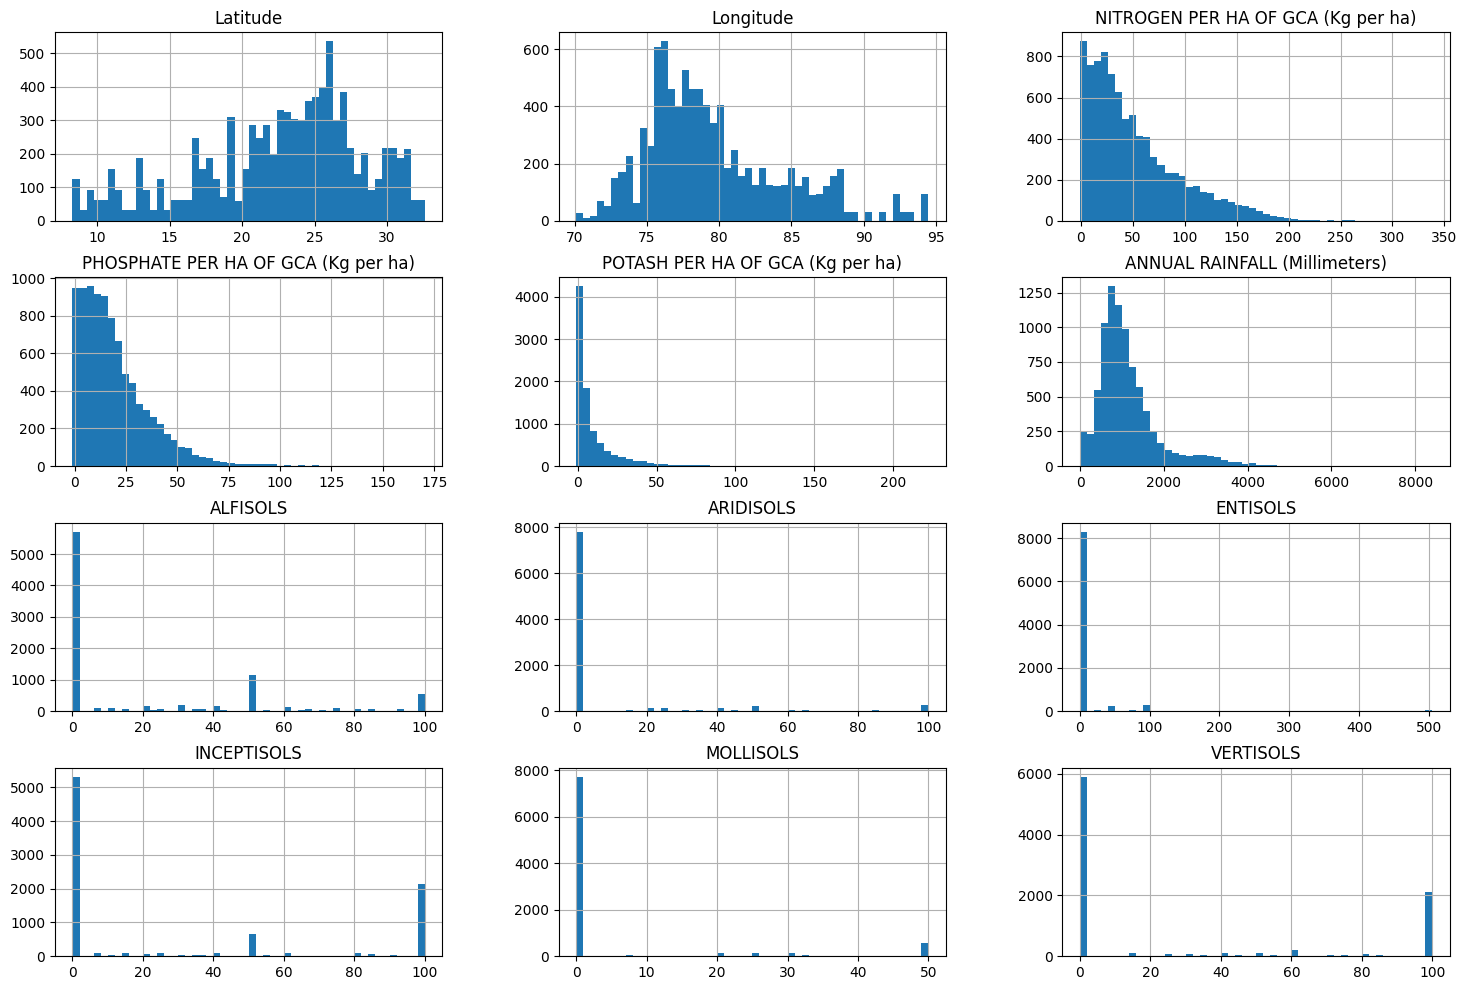

In [26]:
X_train.hist(bins=50, figsize=(18, 12))
plt.show()

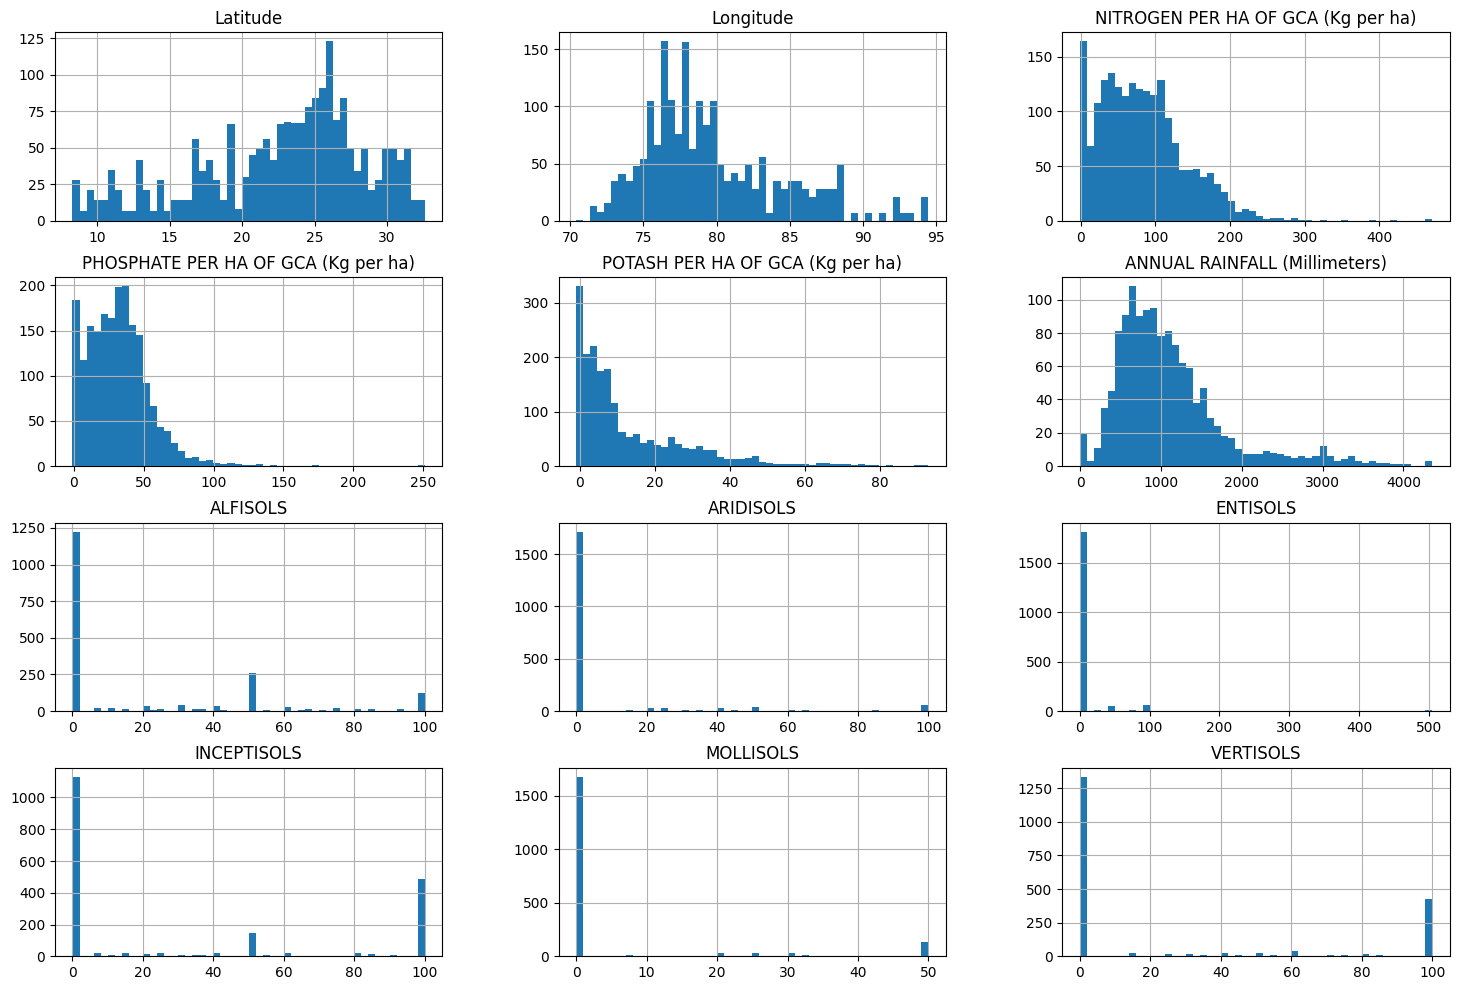

In [27]:
X_test.hist(bins=50, figsize=(18, 12))
plt.show()

# Data cleaning and base features imputation

Part of this is already been done to the soil type data (transforming the categorical [soil compositional data] to numerical)

In [28]:
print(X_train.info())
print(X_train.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 8992 entries, 0 to 10953
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Latitude                             8992 non-null   float64
 1   Longitude                            8992 non-null   float64
 2   NITROGEN PER HA OF GCA (Kg per ha)   8973 non-null   float64
 3   PHOSPHATE PER HA OF GCA (Kg per ha)  8973 non-null   float64
 4   POTASH PER HA OF GCA (Kg per ha)     8973 non-null   float64
 5   ANNUAL RAINFALL (Millimeters)        8426 non-null   float64
 6   ALFISOLS                             8964 non-null   float64
 7   ARIDISOLS                            8964 non-null   float64
 8   ENTISOLS                             8964 non-null   float64
 9   INCEPTISOLS                          8964 non-null   float64
 10  MOLLISOLS                            8964 non-null   float64
 11  VERTISOLS                         

There is a total of 8994 entries there are some missing values of fertilizers, annual rainfall, and soil types. Moreover, there are some missing value that is entered as -1, which likely to mean no record, we'll be replacing the value with Nan first and then impute.

In [29]:
# to be sure check with data admin
median_imputer = SimpleImputer(strategy='median') # given our distribution median is the most robust
replace_negative_1 = FunctionTransformer(lambda X: np.where(X ==-1, np.nan, X))

X_train_neg1 = replace_negative_1.fit_transform(X_train)
X_train_mean = median_imputer.fit_transform(X_train_neg1)

X_train = pd.DataFrame(X_train_mean, columns=X_train.columns, index=X_train.index)
X_train.describe()

Latitude    Longitude  NITROGEN PER HA OF GCA (Kg per ha)  \
count  8992.000000  8992.000000                         8992.000000   
mean     22.618939    79.548888                           52.208541   
std       5.746414     4.763262                           43.913919   
min       8.300000    70.100000                            0.000000   
25%      19.100000    76.200000                           19.295000   
50%      23.700000    78.500000                           39.585000   
75%      26.500000    82.000000                           73.935000   
max      32.600000    94.500000                          338.370000   

       PHOSPHATE PER HA OF GCA (Kg per ha)  POTASH PER HA OF GCA (Kg per ha)  \
count                          8992.000000                       8992.000000   
mean                             19.686744                          9.218879   
std                              16.635419                         13.483456   
min                               0.000000                          0.000000   
25%                               7.690000                          1.250000   
50%                              15.690000                          4.000000   
75%                              27.202500                         11.080000   
max                             170.360000                        222.540000   

       ANNUAL RAINFALL (Millimeters)     ALFISOLS    ARIDISOLS     ENTISOLS  \
count                    8992.000000  8992.000000  8992.000000  8992.000000   
mean                     1141.498143    19.891292     7.090191     6.892238   
std                       695.933686    31.037558    21.272603    35.476370   
min                         9.800000     0.000000     0.000000     0.000000   
25%                       723.675000     0.000000     0.000000     0.000000   
50%                       976.700000     0.000000     0.000000     0.000000   
75%                      1328.100000    50.000000     0.000000     0.000000   
max                      8409.000000   100.000000   100.000000   505.000000   

       INCEPTISOLS    MOLLISOLS    VERTISOLS  
count  8992.000000  8992.000000  8992.000000  
mean     31.280583     5.064780    28.525912  
std      42.504528    13.726553    42.595599  
min       0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000  
75%      80.000000     0.000000    70.000000  
max     100.000000    50.000000   100.000000

# Feature engineering

**Soil × Fertilizer interactions**

Different soils respond differently to nutrients.

**Fertilizer ratios**

Instead of raw N, P, K, you can compute ratios like N/P, N/K, or N/(P+K).

In agriculture, N:P:K ratio is essential for optimal growth.

In [30]:
soil_cols = soil_final_list
fert_cols = ['NITROGEN PER HA OF GCA (Kg per ha)',
             'PHOSPHATE PER HA OF GCA (Kg per ha)',
             'POTASH PER HA OF GCA (Kg per ha)']

# Copy the original DataFrame
X_train_solxfert = X_train.copy()

# Add soil × fertilizer interactions
for soil in soil_cols:
    for fert in fert_cols:
        X_train_solxfert[f"{soil}_x_{fert}"] = X_train[soil] * X_train[fert]

print(X_train_solxfert.describe())

          Latitude    Longitude  NITROGEN PER HA OF GCA (Kg per ha)  \
count  8992.000000  8992.000000                         8992.000000   
mean     22.618939    79.548888                           52.208541   
std       5.746414     4.763262                           43.913919   
min       8.300000    70.100000                            0.000000   
25%      19.100000    76.200000                           19.295000   
50%      23.700000    78.500000                           39.585000   
75%      26.500000    82.000000                           73.935000   
max      32.600000    94.500000                          338.370000   

       PHOSPHATE PER HA OF GCA (Kg per ha)  POTASH PER HA OF GCA (Kg per ha)  \
count                          8992.000000                       8992.000000   
mean                             19.686744                          9.218879   
std                              16.635419                         13.483456   
min                               0.0000

In [31]:
combined_train_solxfert = pd.concat([X_train_solxfert, y_train], axis=1)

combined_train_solxfert = combined_train_solxfert.corr(numeric_only=True)
combined_train_solxfert[yield_target_col].sort_values(ascending=False)

RICE YIELD (Kg per ha)                               1.000000
NITROGEN PER HA OF GCA (Kg per ha)                   0.623886
PHOSPHATE PER HA OF GCA (Kg per ha)                  0.556986
POTASH PER HA OF GCA (Kg per ha)                     0.445604
ALFISOLS_x_NITROGEN PER HA OF GCA (Kg per ha)        0.383410
ALFISOLS_x_PHOSPHATE PER HA OF GCA (Kg per ha)       0.362946
ALFISOLS_x_POTASH PER HA OF GCA (Kg per ha)          0.343634
INCEPTISOLS_x_NITROGEN PER HA OF GCA (Kg per ha)     0.334466
INCEPTISOLS_x_PHOSPHATE PER HA OF GCA (Kg per ha)    0.321955
ARIDISOLS_x_NITROGEN PER HA OF GCA (Kg per ha)       0.283266
ARIDISOLS_x_PHOSPHATE PER HA OF GCA (Kg per ha)      0.280990
ARIDISOLS_x_POTASH PER HA OF GCA (Kg per ha)         0.277504
ALFISOLS                                             0.236519
ARIDISOLS                                            0.213787
INCEPTISOLS_x_POTASH PER HA OF GCA (Kg per ha)       0.166978
INCEPTISOLS                                          0.152121
ENTISOLS_x_PHOSPHATE PER HA OF GCA (Kg per ha)       0.132634
ENTISOLS_x_NITROGEN PER HA OF GCA (Kg per ha)        0.119518
ENTISOLS                                             0.107071
ENTISOLS_x_POTASH PER HA OF GCA (Kg per ha)          0.067022
MOLLISOLS_x_POTASH PER HA OF GCA (Kg per ha)         0.002893
MOLLISOLS_x_NITROGEN PER HA OF GCA (Kg per ha)      -0.013452
VERTISOLS_x_POTASH PER HA OF GCA (Kg per ha)        -0.018672
ANNUAL RAINFALL (Millimeters)                       -0.021761
MOLLISOLS_x_PHOSPHATE PER HA OF GCA (Kg per ha)     -0.022940
Longitude                                           -0.100003
VERTISOLS_x_NITROGEN PER HA OF GCA (Kg per ha)      -0.104324
MOLLISOLS                                           -0.152811
VERTISOLS_x_PHOSPHATE PER HA OF GCA (Kg per ha)     -0.157109
Latitude                                            -0.166361
VERTISOLS                                           -0.417436
Name: RICE YIELD (Kg per ha), dtype: float64

In [32]:
X_train_fert_ratio = X_train.copy()

X_train_fert_ratio['N/P_ratio'] = X_train_fert_ratio['NITROGEN PER HA OF GCA (Kg per ha)'] / X_train_fert_ratio['PHOSPHATE PER HA OF GCA (Kg per ha)']
X_train_fert_ratio['N/K_ratio'] = X_train_fert_ratio['NITROGEN PER HA OF GCA (Kg per ha)'] / X_train_fert_ratio['POTASH PER HA OF GCA (Kg per ha)']
X_train_fert_ratio['P/K_ratio'] = X_train_fert_ratio['PHOSPHATE PER HA OF GCA (Kg per ha)'] / X_train_fert_ratio['POTASH PER HA OF GCA (Kg per ha)']
X_train_fert_ratio['N/P+K_ratio'] = X_train_fert_ratio['NITROGEN PER HA OF GCA (Kg per ha)'] / (X_train_fert_ratio['PHOSPHATE PER HA OF GCA (Kg per ha)'] + X_train_fert_ratio['POTASH PER HA OF GCA (Kg per ha)'])
X_train_fert_ratio['K/N+P_ratio'] = X_train_fert_ratio['POTASH PER HA OF GCA (Kg per ha)'] / (X_train_fert_ratio['NITROGEN PER HA OF GCA (Kg per ha)'] + X_train_fert_ratio['PHOSPHATE PER HA OF GCA (Kg per ha)'])
X_train_fert_ratio['P/K+N_ratio'] = X_train_fert_ratio['PHOSPHATE PER HA OF GCA (Kg per ha)'] / (X_train_fert_ratio['POTASH PER HA OF GCA (Kg per ha)'] + X_train_fert_ratio['NITROGEN PER HA OF GCA (Kg per ha)'])
X_train_fert_ratio
X_train_fert_ratio.info()
# there are some inf and nan values because of zero/zero and num/zero from the ratio calculation
# so we'll be replacing the inf with nan and imputing the nan values with 0

<class 'pandas.core.frame.DataFrame'>
Index: 8992 entries, 0 to 10953
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Latitude                             8992 non-null   float64
 1   Longitude                            8992 non-null   float64
 2   NITROGEN PER HA OF GCA (Kg per ha)   8992 non-null   float64
 3   PHOSPHATE PER HA OF GCA (Kg per ha)  8992 non-null   float64
 4   POTASH PER HA OF GCA (Kg per ha)     8992 non-null   float64
 5   ANNUAL RAINFALL (Millimeters)        8992 non-null   float64
 6   ALFISOLS                             8992 non-null   float64
 7   ARIDISOLS                            8992 non-null   float64
 8   ENTISOLS                             8992 non-null   float64
 9   INCEPTISOLS                          8992 non-null   float64
 10  MOLLISOLS                            8992 non-null   float64
 11  VERTISOLS                         

In [33]:
X_train_fert_ratio.replace(np.inf, np.nan, inplace=True)
zero_imputer = SimpleImputer(strategy='constant', fill_value=0)
X_train_fert_ratio = pd.DataFrame(zero_imputer.fit_transform(X_train_fert_ratio),
                                  columns=X_train_fert_ratio.columns,
                                  index=X_train_fert_ratio.index)

X_train_fert_ratio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8992 entries, 0 to 10953
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Latitude                             8992 non-null   float64
 1   Longitude                            8992 non-null   float64
 2   NITROGEN PER HA OF GCA (Kg per ha)   8992 non-null   float64
 3   PHOSPHATE PER HA OF GCA (Kg per ha)  8992 non-null   float64
 4   POTASH PER HA OF GCA (Kg per ha)     8992 non-null   float64
 5   ANNUAL RAINFALL (Millimeters)        8992 non-null   float64
 6   ALFISOLS                             8992 non-null   float64
 7   ARIDISOLS                            8992 non-null   float64
 8   ENTISOLS                             8992 non-null   float64
 9   INCEPTISOLS                          8992 non-null   float64
 10  MOLLISOLS                            8992 non-null   float64
 11  VERTISOLS                         

In [34]:
combined_train_fert_ratio = pd.concat([X_train_fert_ratio, y_train], axis=1)

combined_train_fert_ratio = combined_train_fert_ratio.corr(numeric_only=True)
combined_train_fert_ratio[yield_target_col].sort_values(ascending=False)

RICE YIELD (Kg per ha)                 1.000000
NITROGEN PER HA OF GCA (Kg per ha)     0.623886
PHOSPHATE PER HA OF GCA (Kg per ha)    0.556986
POTASH PER HA OF GCA (Kg per ha)       0.445604
ALFISOLS                               0.236519
ARIDISOLS                              0.213787
K/N+P_ratio                            0.169654
INCEPTISOLS                            0.152121
ENTISOLS                               0.107071
N/P_ratio                              0.038690
N/P+K_ratio                            0.019908
N/K_ratio                             -0.001740
ANNUAL RAINFALL (Millimeters)         -0.021761
P/K_ratio                             -0.062397
Longitude                             -0.100003
MOLLISOLS                             -0.152811
Latitude                              -0.166361
P/K+N_ratio                           -0.200169
VERTISOLS                             -0.417436
Name: RICE YIELD (Kg per ha), dtype: float64

In [35]:
fert_ratio_cols = ['N/P_ratio', 'N/K_ratio', 'P/K_ratio', 'N/P+K_ratio', 'K/N+P_ratio', 'P/K+N_ratio']
X_train_combined = pd.concat([X_train_solxfert, X_train_fert_ratio[fert_ratio_cols]], axis=1)

combined_train_solxfert_fert_ratio = pd.concat([X_train_combined, y_train], axis=1)

combined_train_solxfert_fert_ratio_corr = combined_train_solxfert_fert_ratio.corr(numeric_only=True)
combined_train_solxfert_fert_ratio_corr[yield_target_col].sort_values(ascending=False)
# Note: Correlation results are crop-dependent; selecting a different target crop leads to different correlation patterns.

RICE YIELD (Kg per ha)                               1.000000
NITROGEN PER HA OF GCA (Kg per ha)                   0.623886
PHOSPHATE PER HA OF GCA (Kg per ha)                  0.556986
POTASH PER HA OF GCA (Kg per ha)                     0.445604
ALFISOLS_x_NITROGEN PER HA OF GCA (Kg per ha)        0.383410
ALFISOLS_x_PHOSPHATE PER HA OF GCA (Kg per ha)       0.362946
ALFISOLS_x_POTASH PER HA OF GCA (Kg per ha)          0.343634
INCEPTISOLS_x_NITROGEN PER HA OF GCA (Kg per ha)     0.334466
INCEPTISOLS_x_PHOSPHATE PER HA OF GCA (Kg per ha)    0.321955
ARIDISOLS_x_NITROGEN PER HA OF GCA (Kg per ha)       0.283266
ARIDISOLS_x_PHOSPHATE PER HA OF GCA (Kg per ha)      0.280990
ARIDISOLS_x_POTASH PER HA OF GCA (Kg per ha)         0.277504
ALFISOLS                                             0.236519
ARIDISOLS                                            0.213787
K/N+P_ratio                                          0.169654
INCEPTISOLS_x_POTASH PER HA OF GCA (Kg per ha)       0.166978
INCEPTISOLS                                          0.152121
ENTISOLS_x_PHOSPHATE PER HA OF GCA (Kg per ha)       0.132634
ENTISOLS_x_NITROGEN PER HA OF GCA (Kg per ha)        0.119518
ENTISOLS                                             0.107071
ENTISOLS_x_POTASH PER HA OF GCA (Kg per ha)          0.067022
N/P_ratio                                            0.038690
N/P+K_ratio                                          0.019908
MOLLISOLS_x_POTASH PER HA OF GCA (Kg per ha)         0.002893
N/K_ratio                                           -0.001740
MOLLISOLS_x_NITROGEN PER HA OF GCA (Kg per ha)      -0.013452
VERTISOLS_x_POTASH PER HA OF GCA (Kg per ha)        -0.018672
ANNUAL RAINFALL (Millimeters)                       -0.021761
MOLLISOLS_x_PHOSPHATE PER HA OF GCA (Kg per ha)     -0.022940
P/K_ratio                                           -0.062397
Longitude                                           -0.100003
VERTISOLS_x_NITROGEN PER HA OF GCA (Kg per ha)      -0.104324
MOLLISOLS                                           -0.152811
VERTISOLS_x_PHOSPHATE PER HA OF GCA (Kg per ha)     -0.157109
Latitude                                            -0.166361
P/K+N_ratio                                         -0.200169
VERTISOLS                                           -0.417436
Name: RICE YIELD (Kg per ha), dtype: float64

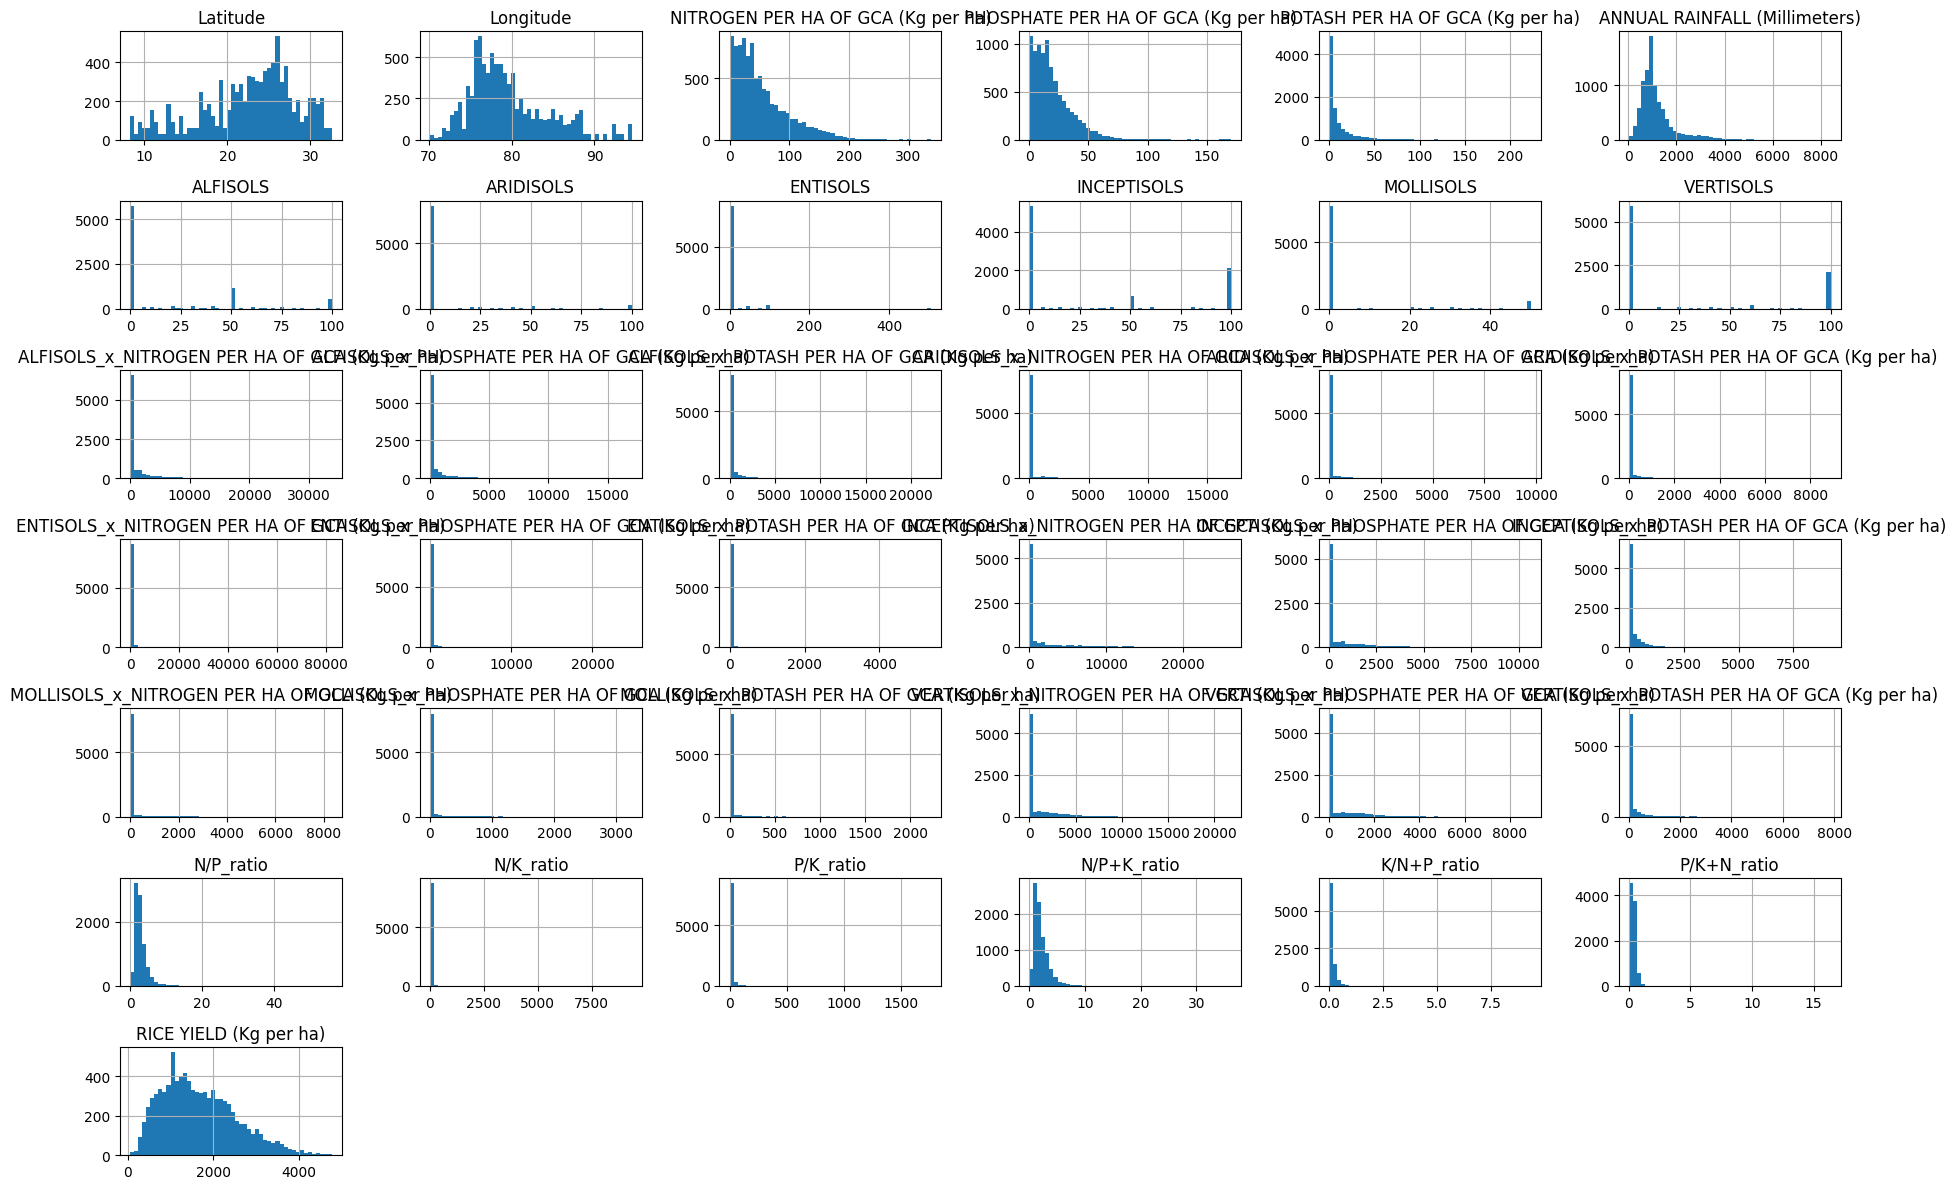

In [36]:
combined_train_solxfert_fert_ratio.hist(bins=50, figsize=(18, 12))
plt.tight_layout()

# Transformation

Transform features/attributes with heavy tail
with many instance value clustered near zero log1p fits very well

<Axes: >

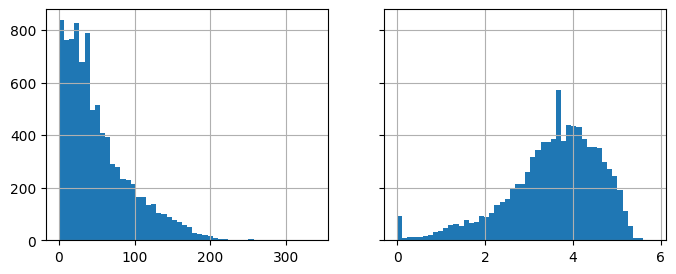

In [37]:
# let's try to transform one of the skewed distribution for example
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
X_train_combined['NITROGEN PER HA OF GCA (Kg per ha)'].hist(bins=50, ax=axs[0])
X_train_combined['NITROGEN PER HA OF GCA (Kg per ha)'].apply(np.log1p).hist(bins=50, ax=axs[1])

/tmp/ipython-input-354542697.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)


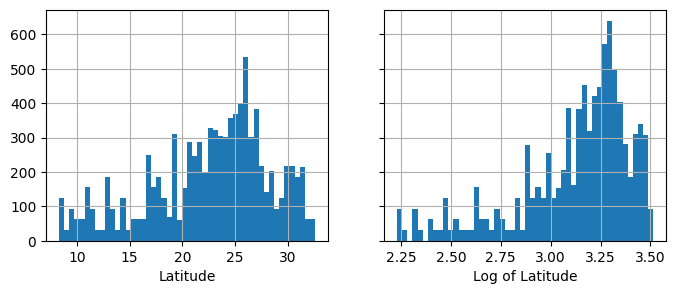

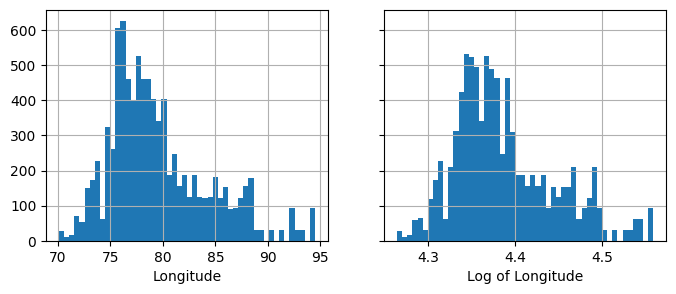

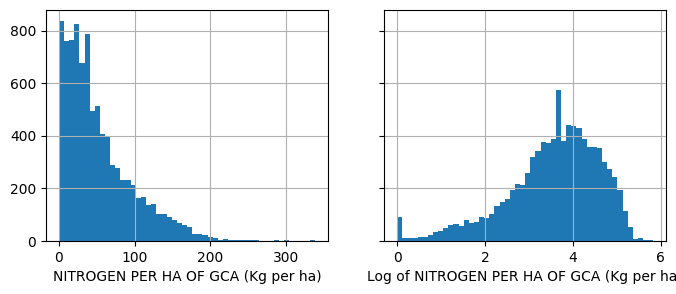

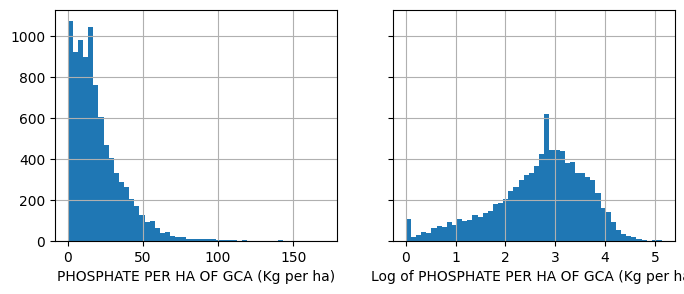

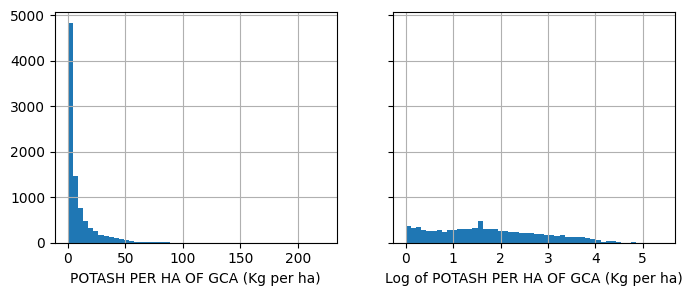

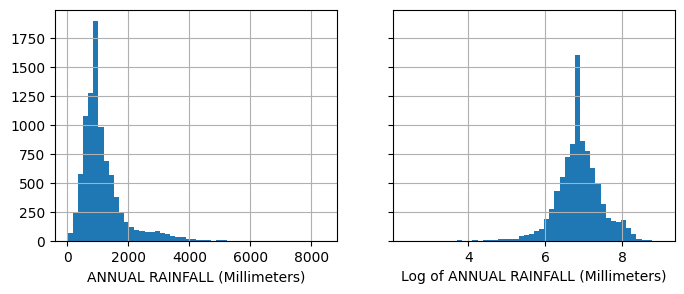

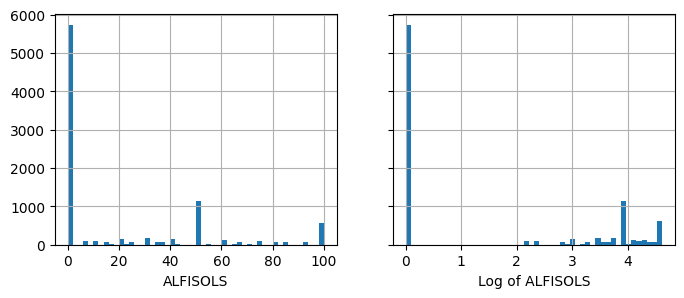

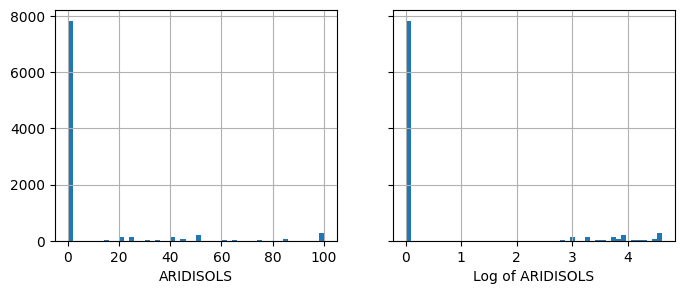

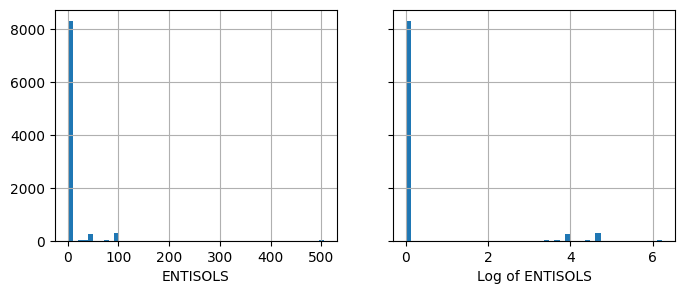

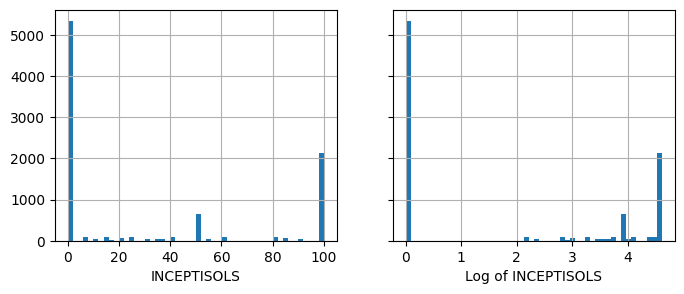

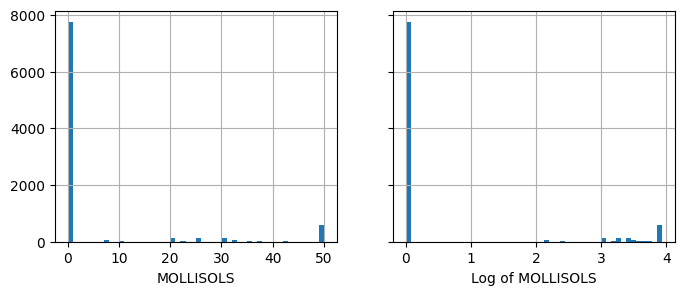

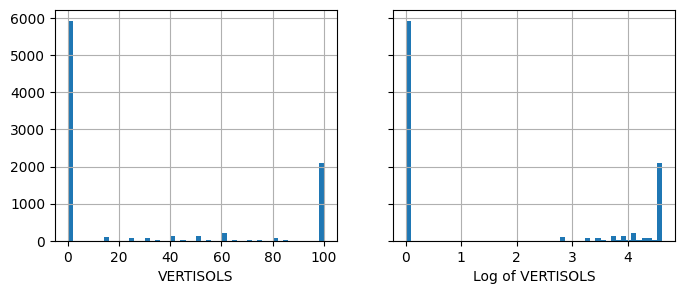

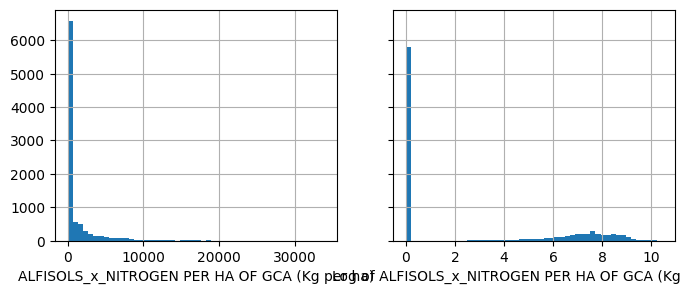

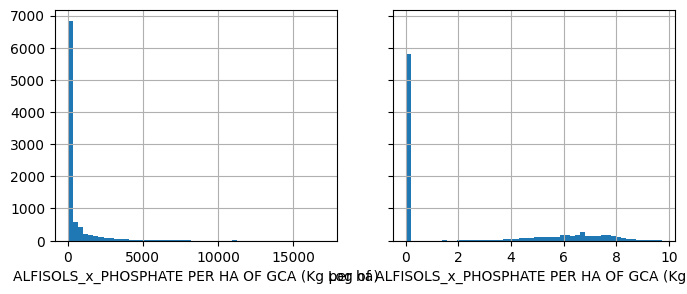

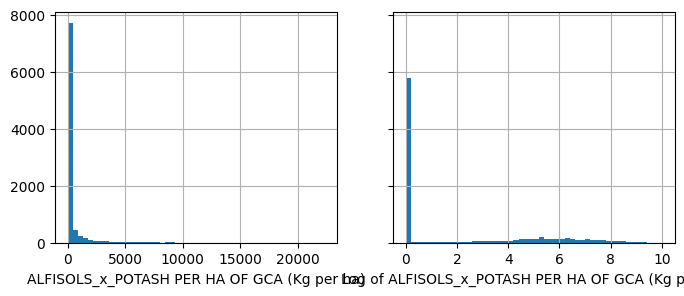

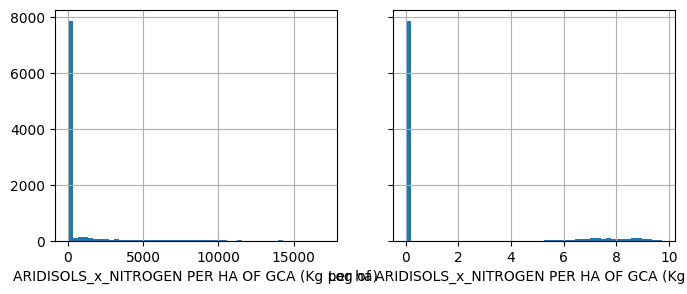

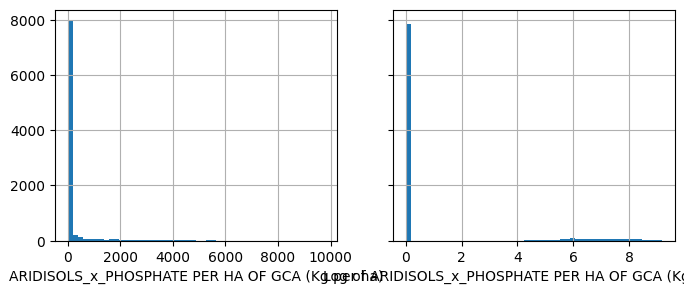

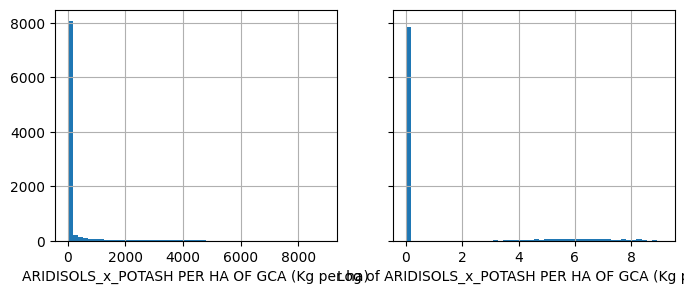

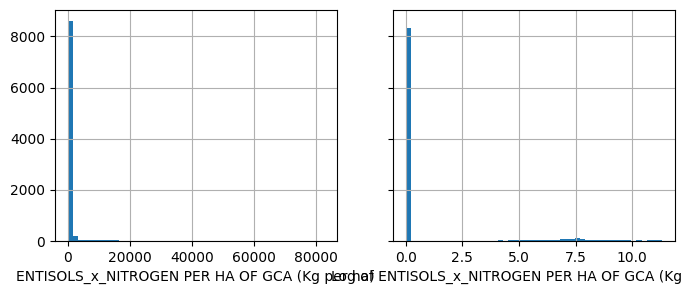

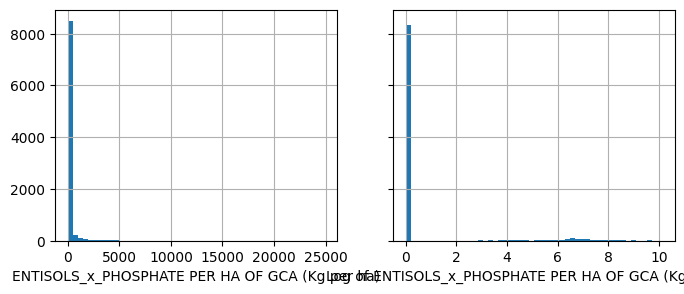

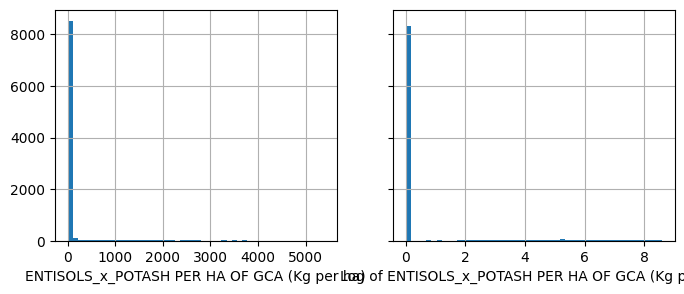

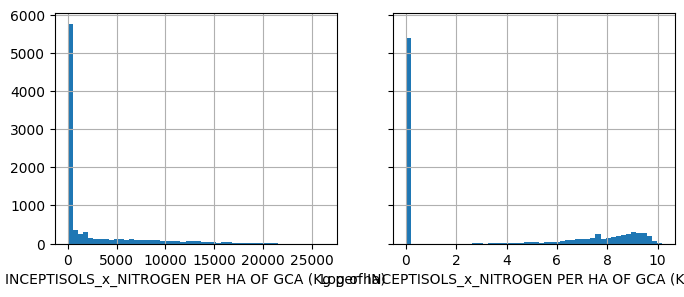

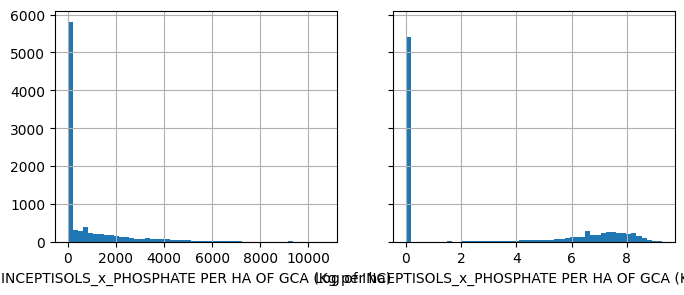

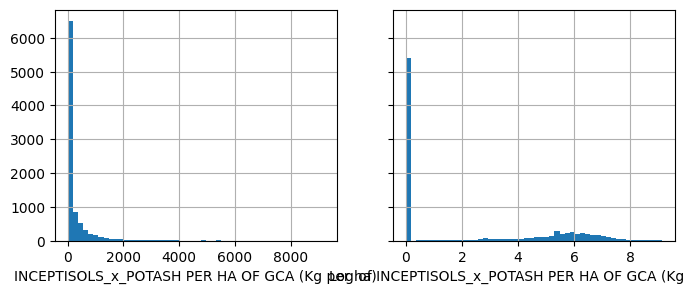

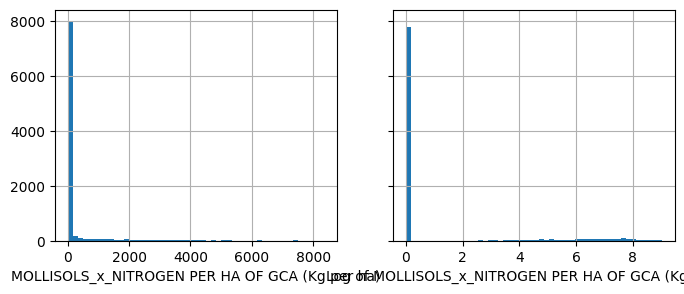

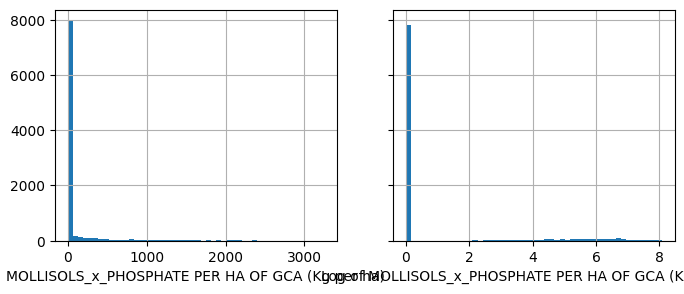

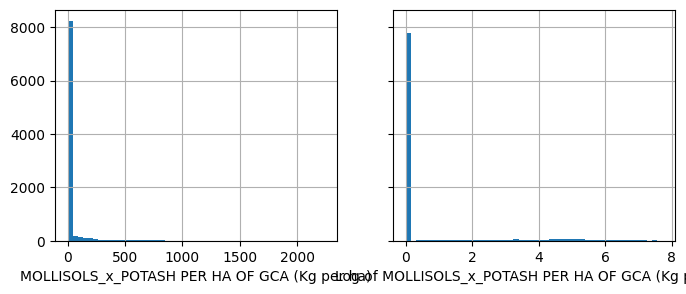

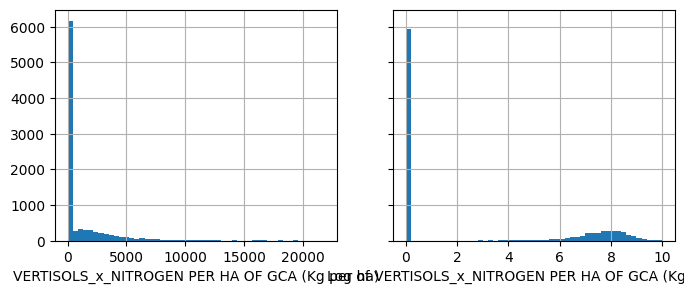

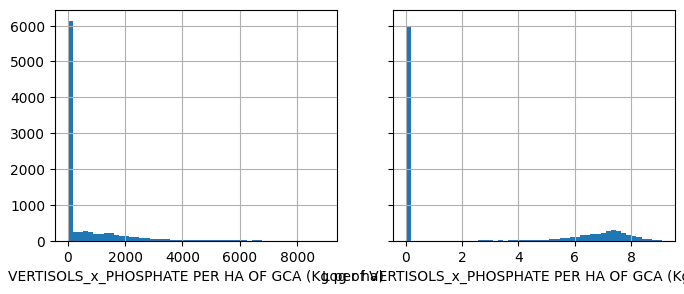

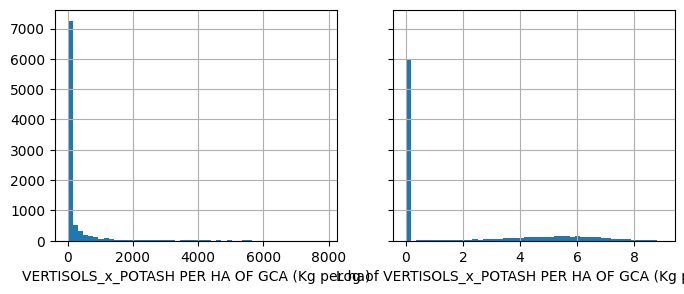

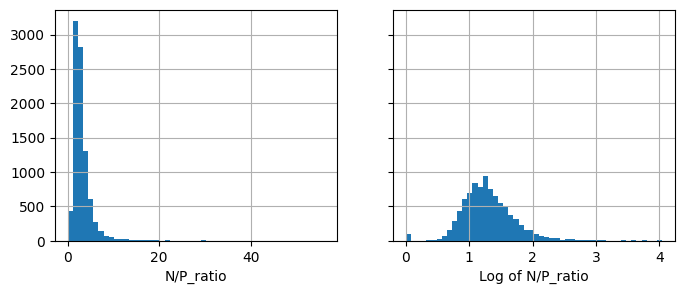

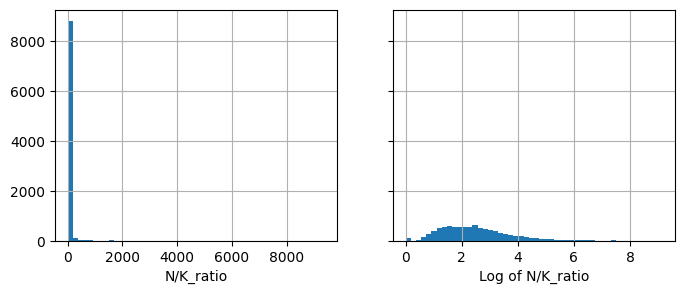

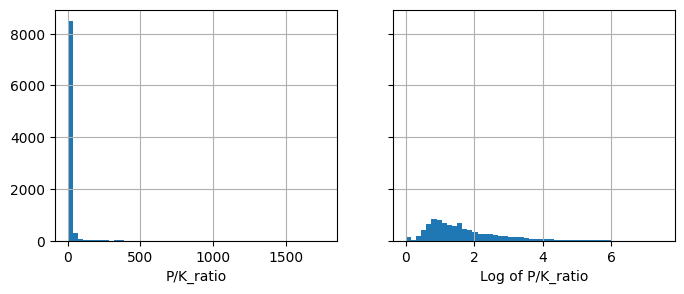

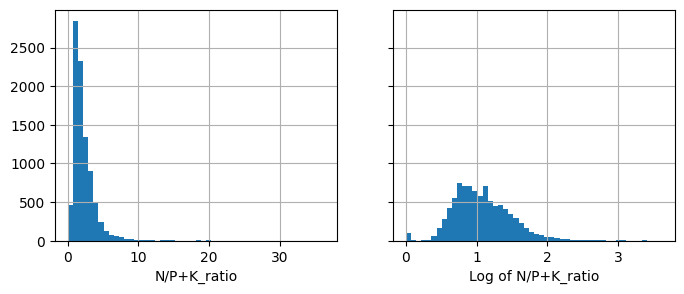

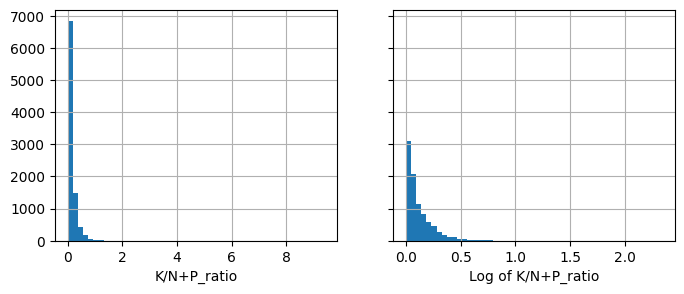

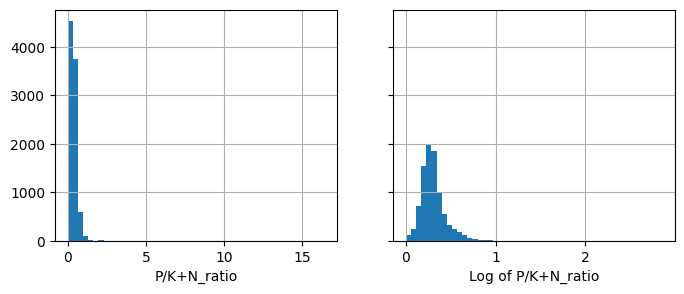

In [38]:
for col in X_train_combined.columns:
  fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
  X_train_combined[col].hist(bins=50, ax=axs[0])
  X_train_combined[col].apply(np.log1p).hist(bins=50, ax=axs[1])
  axs[0].set_xlabel(col)
  axs[1].set_xlabel(f"Log of {col}")

# we'll be apply log1p transformation for every attributes except the soil type which is a compositional attribute
# we'll also won't be transforming the target variable y

we'll then do the feature scaling, but for this we'll instead do it in the pipeline in the following section using sklearn

# Pipeline

In this step, we apply the previously defined preprocessing pipeline to format the input data and perform feature engineering so that it can be used effectively by the model in the next section


In [39]:
print(X_train.columns)
print(X_train_combined.columns)
print(X_train_combined.shape)

Index(['Latitude', 'Longitude', 'NITROGEN PER HA OF GCA (Kg per ha)',
       'PHOSPHATE PER HA OF GCA (Kg per ha)',
       'POTASH PER HA OF GCA (Kg per ha)', 'ANNUAL RAINFALL (Millimeters)',
       'ALFISOLS', 'ARIDISOLS', 'ENTISOLS', 'INCEPTISOLS', 'MOLLISOLS',
       'VERTISOLS'],
      dtype='object')
Index(['Latitude', 'Longitude', 'NITROGEN PER HA OF GCA (Kg per ha)',
       'PHOSPHATE PER HA OF GCA (Kg per ha)',
       'POTASH PER HA OF GCA (Kg per ha)', 'ANNUAL RAINFALL (Millimeters)',
       'ALFISOLS', 'ARIDISOLS', 'ENTISOLS', 'INCEPTISOLS', 'MOLLISOLS',
       'VERTISOLS', 'ALFISOLS_x_NITROGEN PER HA OF GCA (Kg per ha)',
       'ALFISOLS_x_PHOSPHATE PER HA OF GCA (Kg per ha)',
       'ALFISOLS_x_POTASH PER HA OF GCA (Kg per ha)',
       'ARIDISOLS_x_NITROGEN PER HA OF GCA (Kg per ha)',
       'ARIDISOLS_x_PHOSPHATE PER HA OF GCA (Kg per ha)',
       'ARIDISOLS_x_POTASH PER HA OF GCA (Kg per ha)',
       'ENTISOLS_x_NITROGEN PER HA OF GCA (Kg per ha)',
       'ENTISOLS_x_PHOS

In [102]:
soil_cols = soil_final_list #this include 'ALFISOLS', 'ARIDISOLS', 'ENTISOLS',
                            # 'INCEPTISOLS', 'MOLLISOLS', 'VERTISOLS'
fert_cols = [
    'NITROGEN PER HA OF GCA (Kg per ha)',
    'PHOSPHATE PER HA OF GCA (Kg per ha)',
    'POTASH PER HA OF GCA (Kg per ha)']
geo_cols = ['Latitude', 'Longitude']
rain_cols = ['ANNUAL RAINFALL (Millimeters)']

class SoilFertInteraction(BaseEstimator, TransformerMixin):
    def __init__(self, soil_cols, fert_cols):
        self.soil_cols = soil_cols
        self.fert_cols = fert_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.soil_cols + self.fert_cols)

        interactions = [
            X[soil].values * X[fert].values
            for soil in self.soil_cols
              for fert in self.fert_cols
        ]
        return np.column_stack(interactions)

    def get_feature_names_out(self, input_features=None):
        return [
            f"{soil} × {fert}"
            for soil in self.soil_cols
              for fert in self.fert_cols
        ]


class FertRatio(BaseEstimator, TransformerMixin):
    def __init__(self, fert_cols):
        self.fert_cols = fert_cols

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.fert_cols)

        N, P, K = (X[fert].values for fert in self.fert_cols)

        eps = 1e-8 # add epsilon to avoid divide-by-zero warnings
        ratios = np.column_stack([
            N / (P + eps),
            N / (K + eps),
            P / (K + eps),
            N / (P + K + eps),
            K / (N + P + eps),
            P / (K + N + eps),
        ])

        ratios = np.where(np.isinf(ratios), np.nan, ratios)
        return np.nan_to_num(ratios, nan=0.0)

    def get_feature_names_out(self, input_features=None):
        return np.array([
            "N/P_ratio", "N/K_ratio", "P/K_ratio",
            "N/P+K_ratio", "K/N+P_ratio", "P/K+N_ratio"
        ])


replace_negative = FunctionTransformer(
    lambda X: np.where(X < 0, np.nan, X),
    feature_names_out="one-to-one"
)

scale_0_to_1 = FunctionTransformer(lambda X: X / 100.0,
    feature_names_out="one-to-one")

log1p = FunctionTransformer(np.log1p,
    feature_names_out="one-to-one")

preprocessing = ColumnTransformer(
    transformers=[
        ("fert",
         make_pipeline(
             replace_negative,
             SimpleImputer(strategy="median"),
             log1p,
             StandardScaler()),
         fert_cols),

        ("soil", make_pipeline(SimpleImputer(strategy="median"), scale_0_to_1),
         soil_cols),

        ("geo", make_pipeline(SimpleImputer(strategy="median"), StandardScaler()),
         geo_cols),

        ("rain", make_pipeline(replace_negative, SimpleImputer(strategy="median"), StandardScaler()),
         rain_cols),

        # Soil × fertilizer interactions
        ("soilxfert",
         make_pipeline(replace_negative, SimpleImputer(strategy="median"),
                       SoilFertInteraction(soil_cols, fert_cols),
                       log1p,
                       StandardScaler()),
         soil_cols + fert_cols),

        # fertilizer ratios
        ("fert_ratio",
         make_pipeline(FertRatio(fert_cols), SimpleImputer(strategy="median"),
        StandardScaler()),
         fert_cols),
    ],
    remainder="drop",
    # verbose_feature_names_out=False
)

X_train_preprocessed = preprocessing.fit_transform(X_train)
final_feature_names = preprocessing.get_feature_names_out()
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=final_feature_names)

In [90]:
print(preprocessing.get_feature_names_out())
print(X_train_preprocessed_df.head(3))

['fert__NITROGEN PER HA OF GCA (Kg per ha)'
 'fert__PHOSPHATE PER HA OF GCA (Kg per ha)'
 'fert__POTASH PER HA OF GCA (Kg per ha)' 'soil__ALFISOLS'
 'soil__ARIDISOLS' 'soil__ENTISOLS' 'soil__INCEPTISOLS' 'soil__MOLLISOLS'
 'soil__VERTISOLS' 'geo__Latitude' 'geo__Longitude'
 'rain__ANNUAL RAINFALL (Millimeters)'
 'soilxfert__ALFISOLS × NITROGEN PER HA OF GCA (Kg per ha)'
 'soilxfert__ALFISOLS × PHOSPHATE PER HA OF GCA (Kg per ha)'
 'soilxfert__ALFISOLS × POTASH PER HA OF GCA (Kg per ha)'
 'soilxfert__ARIDISOLS × NITROGEN PER HA OF GCA (Kg per ha)'
 'soilxfert__ARIDISOLS × PHOSPHATE PER HA OF GCA (Kg per ha)'
 'soilxfert__ARIDISOLS × POTASH PER HA OF GCA (Kg per ha)'
 'soilxfert__ENTISOLS × NITROGEN PER HA OF GCA (Kg per ha)'
 'soilxfert__ENTISOLS × PHOSPHATE PER HA OF GCA (Kg per ha)'
 'soilxfert__ENTISOLS × POTASH PER HA OF GCA (Kg per ha)'
 'soilxfert__INCEPTISOLS × NITROGEN PER HA OF GCA (Kg per ha)'
 'soilxfert__INCEPTISOLS × PHOSPHATE PER HA OF GCA (Kg per ha)'
 'soilxfert__INCEPTI

# Model testing and shortlisting

The required modeling and evaluation modules are imported at this stage to keep earlier sections focused on data preparation and preprocessing.

This part may take abit long to run since we're fitting multiple models

In [83]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(X_train, y_train)
lin_rmse = -cross_val_score(lin_reg, X_train, y_train,
                              scoring='neg_root_mean_squared_error', cv=5)
print(lin_rmse)
pd.Series(lin_rmse).describe()

[ 535.09014114  841.76459382 1329.39746534  564.97561488  653.59429323]


count       5.000000
mean      784.964422
std       327.003035
min       535.090141
25%       564.975615
50%       653.594293
75%       841.764594
max      1329.397465
dtype: float64

In [84]:
from sklearn.neighbors import KNeighborsRegressor

knn_reg = make_pipeline(preprocessing, KNeighborsRegressor(n_neighbors=5))
knn_rmse = -cross_val_score(knn_reg, X_train, y_train,
                              scoring='neg_root_mean_squared_error', cv=5)
print(knn_rmse)
pd.Series(knn_rmse).describe()

[536.86565255 715.88327008 850.44090473 512.64025963 534.47070664]


count      5.000000
mean     630.060159
std      147.938561
min      512.640260
25%      534.470707
50%      536.865653
75%      715.883270
max      850.440905
dtype: float64

In [85]:
from sklearn.svm import SVR

svr_reg = make_pipeline(preprocessing, SVR(kernel='rbf', C=10, epsilon=0.1))
svr_rmse = -cross_val_score(svr_reg, X_train, y_train,
                            scoring='neg_root_mean_squared_error', cv=5)
print(svr_rmse)
pd.Series(svr_rmse).describe()

[506.13168054 760.44823098 839.60225876 406.40277139 491.25319384]


count      5.000000
mean     600.767627
std      187.927477
min      406.402771
25%      491.253194
50%      506.131681
75%      760.448231
max      839.602259
dtype: float64

In [86]:
from sklearn.ensemble import RandomForestRegressor

forest_reg_rmse = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_reg_rmse = -cross_val_score(forest_reg_rmse, X_train, y_train,
                                scoring='neg_root_mean_squared_error', cv=5)
print(forest_reg_rmse)
pd.Series(forest_reg_rmse).describe()

[534.70875135 683.37615199 769.89145948 464.79437665 534.48966739]


count      5.000000
mean     597.452081
std      125.117288
min      464.794377
25%      534.489667
50%      534.708751
75%      683.376152
max      769.891459
dtype: float64

In [87]:
from sklearn.ensemble import ExtraTreesRegressor

extra_trees = make_pipeline(preprocessing, ExtraTreesRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1)
)

extra_rmse = -cross_val_score(extra_trees, X_train, y_train,
                              scoring='neg_root_mean_squared_error', cv=5)

print(extra_rmse)
pd.Series(extra_rmse).describe()

[465.63610403 657.95018539 743.17847773 424.95265047 496.41482979]


count      5.000000
mean     557.626449
std      136.295479
min      424.952650
25%      465.636104
50%      496.414830
75%      657.950185
max      743.178478
dtype: float64

In [107]:
from sklearn.ensemble import HistGradientBoostingRegressor

hist_gbr = make_pipeline(preprocessing, HistGradientBoostingRegressor(random_state=42))

hist_rmse = -cross_val_score(hist_gbr, X_train, y_train,
                            scoring='neg_root_mean_squared_error', cv=5)
print(hist_rmse)
pd.Series(hist_rmse).describe()

[468.79081436 667.11855656 733.57693941 403.11028442 534.60501425]


count      5.000000
mean     561.440322
std      137.086989
min      403.110284
25%      468.790814
50%      534.605014
75%      667.118557
max      733.576939
dtype: float64

In [108]:
from xgboost import XGBRegressor

xgb_reg = make_pipeline(preprocessing,
        XGBRegressor(
        random_state=42,
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1
    )
)

xgb_reg_rmse = -cross_val_score(xgb_reg, X_train, y_train,
                                scoring='neg_root_mean_squared_error', cv=5)
print(xgb_reg_rmse)
pd.Series(xgb_reg_rmse).describe()

[483.80622131 644.72168025 779.84607893 407.21205804 531.94811295]


count      5.000000
mean     569.506830
std      145.769268
min      407.212058
25%      483.806221
50%      531.948113
75%      644.721680
max      779.846079
dtype: float64

# Fine-Tuning model

For the rice crop target, preliminary model evaluation was conducted using multiple regression algorithms.
Based on cross-validated performance, **HistGradientBoostingRegressor** and **ExtraTreesRegressor**
were selected for further fine-tuning, as they achieved the lowest rmse among the tested models.


In [114]:
full_pipeline_gbr = Pipeline([
    ("preprocessing", preprocessing),
    ("model", HistGradientBoostingRegressor(random_state=42))
])

param_distribs = {
    "model__max_iter": [100, 200, 300, 500],
    "model__learning_rate": [0.01, 0.03, 0.05, 0.1],
    "model__max_depth": [2, 3, 4, 5, None],
    "model__min_samples_leaf": [5, 10, 20, 50],
    "model__l2_regularization": [0.0, 0.1, 1.0, 10.0]
}

rnd_search_hist = RandomizedSearchCV(
    full_pipeline_gbr,
    param_distributions=param_distribs,
    n_iter=20,
    cv=5,
    scoring="neg_root_mean_squared_error",
    random_state=42,
    n_jobs=-1,
    verbose=2
)

rnd_search_hist.fit(X_train, y_train)

hist_best_rmse = -rnd_search_hist.best_score_
hist_best_params = rnd_search_hist.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [115]:
hist_best_rmse, hist_best_params

(np.float64(545.7315299848617),
 {'model__min_samples_leaf': 5,
  'model__max_iter': 500,
  'model__max_depth': 4,
  'model__learning_rate': 0.01,
  'model__l2_regularization': 0.0})

In [129]:
full_pipelin_extra = Pipeline([
    ("preprocessing", preprocessing),
    ("model", ExtraTreesRegressor(
        random_state=42,
        n_jobs=-1
    ))
])

param_distribs = {
    "model__n_estimators": [200, 400, 600],
    "model__max_depth": [None, 10, 20, 40],
    "model__min_samples_leaf": [1, 2, 5, 10],
    "model__max_features": ["sqrt", "log2", 0.5]
}

rnd_search_extra = RandomizedSearchCV(
    full_pipelin_extra,
    param_distributions=param_distribs,
    n_iter=20,
    cv=5,
    scoring="neg_root_mean_squared_error",
    random_state=42,
    n_jobs=-1,
    verbose=2
)
rnd_search_extra.fit(X_train, y_train)
extra_best_rmse = -rnd_search_extra.best_score_
extra_best_params = rnd_search_extra.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [130]:
extra_best_rmse, extra_best_params

(np.float64(558.5059357340297),
 {'model__n_estimators': 200,
  'model__min_samples_leaf': 2,
  'model__max_features': 0.5,
  'model__max_depth': None})

After hyperparameter optimization using RandomizedSearchCV, **HistGradientBoostingRegressor** achieved the lowest rmse of **545.73**
(compared to **561.44** prior to tuning).

The selected hyperparameters were:

*   model__min_samples_leaf': 5,
*   'model__max_iter': 500,
*   'model__max_depth': 4,
*   'model__learning_rate': 0.01,
*   'model__l2_regularization': 0.0

The model will be refit using the full training dataset, after which further diagnostic analysis
and performance evaluation will be conducted.

In [125]:
final_model_hist = rnd_search_hist.best_estimator_

y_test_pred_hist = final_model_hist.predict(X_test)

test_rmse_hist = root_mean_squared_error(y_test, y_test_pred_hist)

print(f'Test rmse = {test_rmse_hist}')
print("Mean rice yield = 1792.27 kg/ha → relative error ≈ 41%")

"""
The rmse corresponds to ~41% of the average rice yield. This level of error suggests
a highly heterogeneous yield distribution, with many low-yield districts (as observe in the
hist distribution (right skewed). Such variability increases prediction difficulty,
especially when key other key attributes are not modelled  (irrigation, management practices).
"""

Test rmse = 741.9420314582906
Mean rice yield = 1792.27 kg/ha → relative error ≈ 41%


'\nThe rmse corresponds to ~41% of the average rice yield. This level of error suggests\na highly heterogeneous yield distribution, with many low-yield districts (as observe in the\nhist distribution (right skewed). Such variability increases prediction difficulty,\nespecially when key other key attributes are not modelled  (irrigation, management practices).\n'

In [138]:
"""
We additionally evaluate an ExtraTreesRegressor to obtain feature importances,
which help identify influential attributes and inform iterative model improvement.
"""

final_model_extra = rnd_search_extra.best_estimator_

y_test_pred_extra = final_model_extra.predict(X_test)

test_rmse_extra = root_mean_squared_error(y_test, y_test_pred_extra)

print(f'Test rmse = {test_rmse_extra}')
print("Mean rice yield = 1792.27 kg/ha → relative error ≈ 39%\n")

importances_extra = final_model_extra["model"].feature_importances_
feature_names = final_model_extra["preprocessing"].get_feature_names_out()

sorted_importances = sorted(
    zip(importances_extra, feature_names),
    reverse=True)

sorted_importances[:15]

Test rmse = 702.2855558479431
Mean rice yield = 1792.27 kg/ha → relative error ≈    %



[(np.float64(0.13923633023337229), 'fert__NITROGEN PER HA OF GCA (Kg per ha)'),
 (np.float64(0.1311152651843156), 'geo__Latitude'),
 (np.float64(0.10245271540108458),
  'fert__PHOSPHATE PER HA OF GCA (Kg per ha)'),
 (np.float64(0.09404498062414339), 'soil__VERTISOLS'),
 (np.float64(0.07545157339945802), 'geo__Longitude'),
 (np.float64(0.055588426936241796), 'fert__POTASH PER HA OF GCA (Kg per ha)'),
 (np.float64(0.034806774034784986),
  'soilxfert__ALFISOLS × POTASH PER HA OF GCA (Kg per ha)'),
 (np.float64(0.031830934533024345),
  'soilxfert__VERTISOLS × NITROGEN PER HA OF GCA (Kg per ha)'),
 (np.float64(0.026424394541777176),
  'soilxfert__ALFISOLS × NITROGEN PER HA OF GCA (Kg per ha)'),
 (np.float64(0.022119290121663932),
  'soilxfert__ALFISOLS × PHOSPHATE PER HA OF GCA (Kg per ha)'),
 (np.float64(0.02119901048821541),
  'soilxfert__INCEPTISOLS × NITROGEN PER HA OF GCA (Kg per ha)'),
 (np.float64(0.018115171732925033), 'rain__ANNUAL RAINFALL (Millimeters)'),
 (np.float64(0.017358937

Feature importance analysis indicates that fertilizer application rates, particularly nitrogen, are the most influential predictors of rice yield. Geographic variables (latitude and longitude) also exhibit high importance; however, these variables likely act as proxies for multiple underlying factors, including agro-climatic conditions (e.g., sunlight exposure and temperature regimes), irrigation access, and regional differences in farm management intensity and economic resources.

Soil type contributes meaningfully to yield prediction, with Vertisols showing a notable effect. This is consistent with the known agronomic characteristics of Vertisols, which strongly influence water retention and nutrient availability, thereby affecting fertilizer response and crop productivity.

Key note if this model is to adapt for Thailand Agriculture, we need to adapt the model attribute namely the geographical data and note that the climate also play an important role that this model have not capture.

Reference for Thailand soil data (https://iddindee.ldd.go.th/web/data.html)

Reference for India soil data (https://civilspedia.com/soils-of-india/)

Next potential iteration: add climate data (https://www.climatologylab.org/)
